# 뗑컨 몸무게 예측 경진대회

`-` 교호작용을 Clumen_Length와 DeltaC에 대해서만 수행해보기

`-` Clumen_Length는 Island, DeltaC는 Island와 Species에 대해서 수행

`-` 위와 같이 할거면 레이블 인코딩말고 원핫 인코딩도 사용해보자

`-` 일반화 능력 키우는 방법

`1.` 교차검증을 통해 일반화능력을 평가하고 하나의 모델 생성

`2.` 교차검증을 통해 생성한 모델들에 가중치를 주고 합하여 예측하기

`3.` 교차검증을 통해 하이퍼 파라미터값을 찾고 모델 학습은 모든 표본을 사용하기

## 패키지 import 및 데이터 전처리

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/train.csv')

In [3]:
df.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [4]:
df.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 열 이름 변경

In [5]:
df.drop('id', axis = 1, inplace = True) ## id는 필요없으니 제거 

In [6]:
df.isnull().sum()

Species           0
Island            0
Full_Clutch       0
Culmen_Length     0
Culmen_Depth      0
Flipper_Length    0
Sex               3
DeltaN            3
DeltaC            3
Body_Mass         0
dtype: int64

`-` Sex, Delta 15 N, Delta 13 C 컬럼에 결측치가 3개씩 존재한다

In [7]:
## 결측치가 있는 row들을 확인
df[df.isna().sum(axis = 1) > 0]

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Body_Mass
6,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,42.0,20.2,190,NaN,9.13362,-25.09368,4250
8,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,34.1,18.1,193,NaN,NaN,NaN,3475
18,Adelie Penguin (Pygoscelis adeliae),Dream,No,39.8,19.1,184,MALE,NaN,NaN,4650
70,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,46.2,14.4,214,NaN,8.24253,-26.81540,4650
109,Adelie Penguin (Pygoscelis adeliae),Torgersen,Yes,36.6,17.8,185,FEMALE,NaN,NaN,3700


`-` 방사성 동위원소 행의 결측치에는 각각의 중앙값을 넣어주자

In [8]:
df['DeltaN'].fillna(df['DeltaN'].median(), inplace = True)
df['DeltaC'].fillna(df['DeltaC'].median(), inplace = True)

`-` EDA를 보면 알겠지만 Species별로 몸무게가 다르다

`-` 또한 수컷과 암컷간의 차이도 꽤 있다

`-` drop해도 되지만 3개의 데이터가 유실되는 것이기에 Species와 Body_Mass를 통해 결측치에 값을 채워넣자

In [9]:
df.groupby(['Species', 'Sex']).\
agg({'Body_Mass':np.mean}).reset_index()

,Species,Sex,Body_Mass
0,Adelie Penguin (Pygoscelis adeliae),FEMALE,3448.611111
1,Adelie Penguin (Pygoscelis adeliae),MALE,4097.619048
2,Chinstrap penguin (Pygoscelis antarctica),FEMALE,3550.000000
3,Chinstrap penguin (Pygoscelis antarctica),MALE,4018.181818
4,Gentoo penguin (Pygoscelis papua),FEMALE,4707.608696
5,Gentoo penguin (Pygoscelis papua),MALE,5445.833333


`-` 6번 펭귄의 성별은 수컷, 8번은 암컷, 70번은 암컷으로 하자

In [10]:
df.loc[[6,8,70], 'Sex']= ['MALE','FEMALE', 'FEMALE']

`-` 이상으로 결측치 처리는 끝났다

In [11]:
df.isnull().values.any() ## 이제 결측치는 없다

False

## 모델링을 해보자

`-` 뗑컨 데이터셋의 크기는 114로 그리 많지 않다

`-` 그렇기에 overfitting이 일어날 가능성이 꽤 있으며 변수간의 상관관계도 강하다

`-` 이를 해결하기 위해 cost fuction에 규제항을 추가한 릿지, 라쏘, 엘라스틱 넷을 써보자

### preprocessing

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
dt = df.copy()

In [14]:
target = dt['Body_Mass']  ## target
dt = dt.iloc[:, :-1]      ## target 제외한 데이터프레임

`-` 라벨인코딩을 해주자

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
# for col in dt.columns:
#     if dt.dtypes[col] == 'O':
#         encoder = LabelEncoder()    
#         labels = encoder.fit_transform(dt[col])
#         dt[col] = list(labels) 

`-` 위랑 아래랑 똑같음!

In [16]:
species_encoder = LabelEncoder()
species_labels = species_encoder.fit_transform(dt['Species'])
dt['Species'] = list(species_labels) ## Species labelencoding

island_encoder = LabelEncoder()
island_labels = island_encoder.fit_transform(dt['Island'])
dt['Island'] = list(island_labels) ## Island labelencoding

full_clutch_encoder = LabelEncoder()
full_clutch_labels = full_clutch_encoder.fit_transform(dt['Full_Clutch'])
dt['Full_Clutch'] = list(full_clutch_labels) ## Full_Clutch labelencoding

sex_encoder = LabelEncoder()
sex_labels = sex_encoder.fit_transform(dt['Sex'])
dt['Sex'] = list(sex_labels) ## Sex labelencoding

In [17]:
dt.head()

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,2,0,1,50.0,15.3,220,1,8.30515,-25.19017
1,1,1,0,49.5,19.0,200,1,9.63074,-24.34684
2,2,0,1,45.1,14.4,210,0,8.51951,-27.01854
3,2,0,1,44.5,14.7,214,0,8.20106,-26.16524
4,2,0,0,49.6,16.0,225,1,8.38324,-26.84272


`-` 범주형 변수마다 라벨인코딩이 잘 되었다

In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(dt, target, test_size = 0.2, shuffle = True,
                                                      stratify = dt['Species'], random_state = 21) 
## 종의 비율이 train, valid 비슷하도록 세팅함 
## 웃긴건 stratify 설정안해도 한거랑 종별 count가 동일함

`-` 아래는 stratify 설정 안한 버전

In [19]:
x_train_raw, x_valid_raw, y_train_raw, y_valid_raw = train_test_split(dt, target, test_size = 0.2, shuffle = True, random_state = 22) ## 33

## 종의 비율이 train, valid 비슷하도록 세팅함 
## 웃긴건 stratify 설정안해도 한거랑 종별 count가 동일함(seed 21)

## 릿지 회귀(Ridge Regressor)

In [20]:
def RMSE(real, predict):
    return np.sqrt(np.mean(np.square(real - predict)))

In [21]:
from sklearn.linear_model import Ridge

In [21]:
ridge = Ridge(alpha = 10) ## alpha = 10인 릿지 회귀 모형 생성
ridge.fit(x_train, y_train) ## 모델 학습
y_predict = ridge.predict(x_valid) ## 모델 예측
rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
print('이 방정식의 평균 에러는 {:.2f}입니다'.format(rmse))

이 방정식의 평균 에러는 291.16입니다


`-` 여러개의 $\alpha$에 대해 rmse를 계산해보자

In [176]:
alphas = [0.01, 0.1, 1, 10, 50, 100]

## alpha 값들에 대해 rmse를 구함
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    ridge.fit(x_train, y_train) ## 모델 학습
    y_predict = ridge.predict(x_valid) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.01일 때 이 방정식의 평균 에러는 268.04입니다
𝛼가 0.1일 때 이 방정식의 평균 에러는 268.04입니다
𝛼가 1일 때 이 방정식의 평균 에러는 269.10입니다
𝛼가 10일 때 이 방정식의 평균 에러는 291.16입니다
𝛼가 50일 때 이 방정식의 평균 에러는 313.83입니다
𝛼가 100일 때 이 방정식의 평균 에러는 319.01입니다


`-` $\alpha$가 작아질수록 평균 에러가 작아진다

### $\alpha$에 따른 회귀 계수 시각화

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

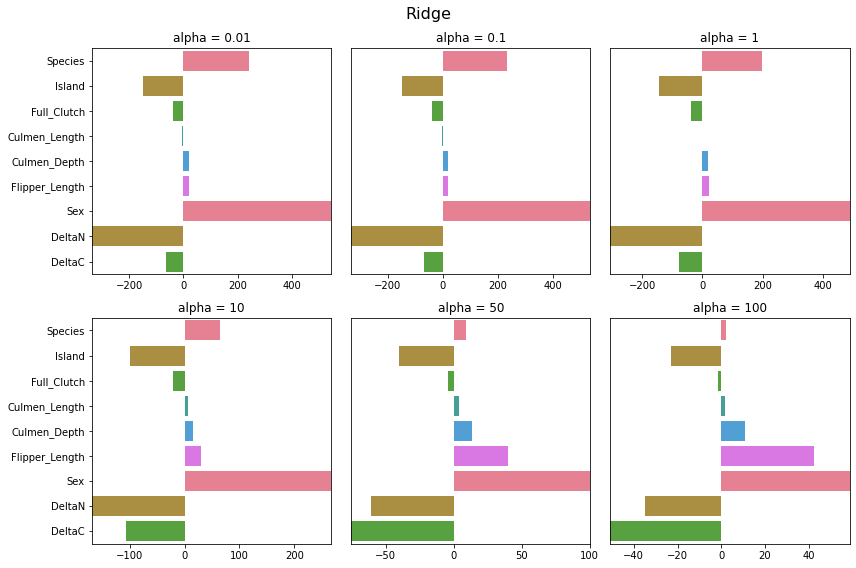

In [214]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
colors = sns.color_palette('husl', 6)
coeff_df = pd.DataFrame()
alphas = [0.01, 0.1, 1, 10, 50, 100]

for i, alpha in enumerate(alphas):
    ridge = Ridge(alpha = alpha)
    ridge.fit(x_train, y_train)

    coeff = pd.Series(data = ridge.coef_, index = x_train.columns)
    colname = 'alpha = ' + str(alpha)
    coeff_df[colname] = coeff

    axs[i//3][i%3].set_title(colname)
    axs[i//3][i%3].set_xlim(min(coeff),max(coeff))
    sns.barplot(x = coeff.values, y = coeff.index, palette = colors, ax = axs[i//3][i%3])
    if i != 0 and i != 3:
        axs[i//3][i%3].set(yticklabels = [])   
        axs[i//3][i%3].set(ylabel = None)
        axs[i//3][i%3].tick_params(left = False)  

fig.suptitle('Ridge', fontsize = 16)
fig.tight_layout()

`-` $\alpha$가 커짐에 따라 회귀계수가 작아진다

## 라쏘 회귀(Lasso Regressor)

In [23]:
from sklearn.linear_model import Lasso

`-` $\alpha$가 커짐에 따라 계수가 $0$되는 항이 많아진다

In [175]:
alphas = [0.01, 0.1, 1, 10, 50, 100]

## alpha 값들에 대해 rmse를 구함
for alpha in alphas:
    lasso = Lasso(alpha = alpha)
    lasso.fit(x_train, y_train) ## 모델 학습
    y_predict = lasso.predict(x_valid) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.01일 때 이 방정식의 평균 에러는 268.00입니다
𝛼가 0.1일 때 이 방정식의 평균 에러는 267.67입니다
𝛼가 1일 때 이 방정식의 평균 에러는 264.49입니다
𝛼가 10일 때 이 방정식의 평균 에러는 255.46입니다
𝛼가 50일 때 이 방정식의 평균 에러는 311.57입니다
𝛼가 100일 때 이 방정식의 평균 에러는 327.98입니다


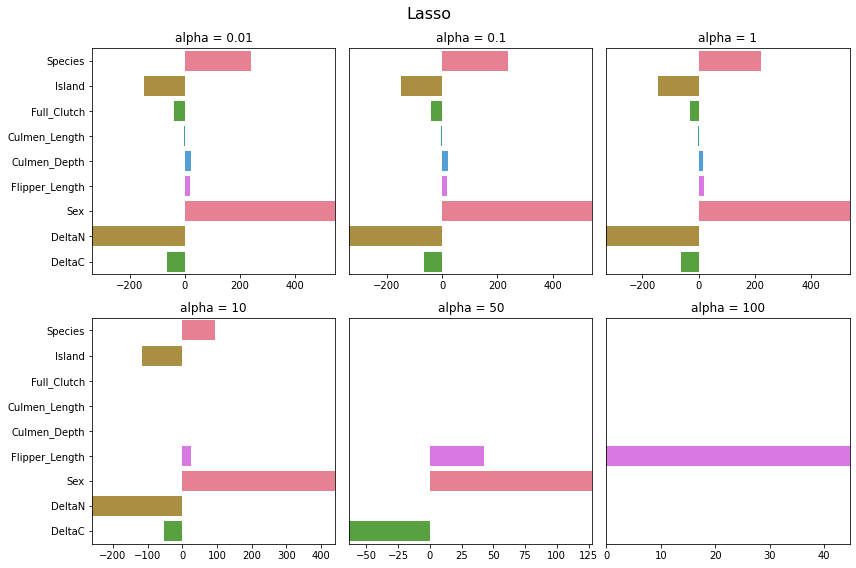

In [215]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
colors = sns.color_palette('husl', 6)
coeff_df = pd.DataFrame()
alphas = [0.01, 0.1, 1, 10, 50, 100]

for i, alpha in enumerate(alphas):
    lasso = Lasso(alpha = alpha)
    lasso.fit(x_train, y_train)

    coeff = pd.Series(data = lasso.coef_, index = x_train.columns)
    colname = 'alpha = ' + str(alpha)
    coeff_df[colname] = coeff

    axs[i//3][i%3].set_title(colname)
    axs[i//3][i%3].set_xlim(min(coeff),max(coeff))
    sns.barplot(x = coeff.values, y = coeff.index, palette = colors, ax = axs[i//3][i%3])
    if i != 0 and i != 3:
        axs[i//3][i%3].set(yticklabels = [])   
        axs[i//3][i%3].set(ylabel = None)
        axs[i//3][i%3].tick_params(left = False)  

fig.suptitle('Lasso', fontsize = 16)
fig.tight_layout()

## 엘라스틱 넷(Elastic Net)

`-` 라쏘 회귀에서의 규제항(L1)과 릿지 회귀에서의 규제항(L2)을 비율에 따라 혼합한 규제항을 사용 

In [30]:
from sklearn.linear_model import ElasticNet

In [198]:
alphas = [0.01, 0.1, 1, 10]
L1_ratios = [0.05, 0.2, 0.5, 0.8, 0.95]
## alpha 값들에 대해 rmse를 구함
for alpha in alphas:
    for L1_ratio in L1_ratios:
        elastic_net = ElasticNet(alpha = alpha, l1_ratio = L1_ratio)
        elastic_net.fit(x_train, y_train) ## 모델 학습
        y_predict = elastic_net.predict(x_valid) ## 모델 예측
        rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
        print('𝛼가 {}이고 L1_raio가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, L1_ratio, rmse))
    print('\n', end = '')

𝛼가 0.01이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 268.85입니다
𝛼가 0.01이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 268.62입니다
𝛼가 0.01이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 268.25입니다
𝛼가 0.01이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 268.04입니다
𝛼가 0.01이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 268.00입니다

𝛼가 0.1이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 288.65입니다
𝛼가 0.1이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 285.76입니다
𝛼가 0.1이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 278.81입니다
𝛼가 0.1이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 270.86입니다
𝛼가 0.1이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 267.96입니다

𝛼가 1이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 318.07입니다
𝛼가 1이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 316.89입니다
𝛼가 1이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 313.02입니다
𝛼가 1이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 301.27입니다
𝛼가 1이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 277.80입니다

𝛼가 10이고 L1_raio가 0.05일 때 이 방정식의 평균 에러는 332.59입니다
𝛼가 10이고 L1_raio가 0.2일 때 이 방정식의 평균 에러는 331.16입니다
𝛼가 10이고 L1_raio가 0.5일 때 이 방정식의 평균 에러는 328.05입니다
𝛼가 10이고 L1_raio가 0.8일 때 이 방정식의 평균 에러는 323.53입니다
𝛼가 10이고 L1_raio가 0.95일 때 이 방정식의 평균 에러는 314.74입니다



`-` 뗑컨 데이터에 대해서는 일라스틱 넷에서 L1_ratio가 높을수록 RMSE가 작다

`-` 릿지, 라쏘와 엘라스틱 넷의 차이를 느끼고자 L1_ratio는 0.5로 하자

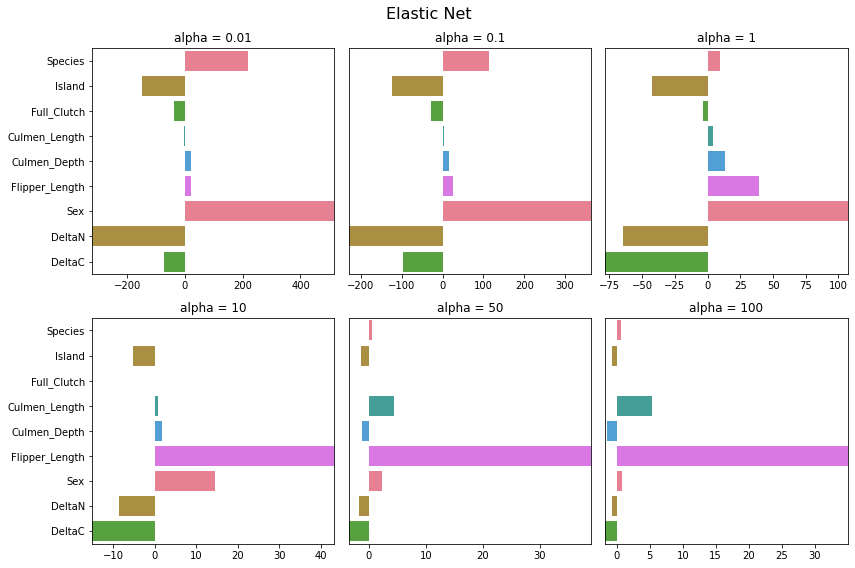

In [216]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8))
colors = sns.color_palette('husl', 6)
coeff_df = pd.DataFrame()
alphas = [0.01, 0.1, 1, 10, 50, 100]

for i, alpha in enumerate(alphas):
    elastic_net = ElasticNet(alpha = alpha)
    elastic_net.fit(x_train, y_train)

    coeff = pd.Series(data = elastic_net.coef_, index = x_train.columns)
    colname = 'alpha = ' + str(alpha)
    coeff_df[colname] = coeff

    axs[i//3][i%3].set_title(colname)
    axs[i//3][i%3].set_xlim(min(coeff),max(coeff))
    sns.barplot(x = coeff.values, y = coeff.index, palette = colors, ax = axs[i//3][i%3])
    if i != 0 and i != 3:
        axs[i//3][i%3].set(yticklabels = [])   
        axs[i//3][i%3].set(ylabel = None)
        axs[i//3][i%3].tick_params(left = False)  

fig.suptitle('Elastic Net', fontsize = 16)
fig.tight_layout()

`-` 회귀계수들이 작아지고 계수가 $0$인 변수도 존재한다

## 라쏘 회귀 + 교호작용 + 표준화

`-` EDA에서는 특별히 교호작용항 추가의 필요성을 느끼지 못했는데 이를 라쏘 회귀를 통해 확인하자

### 교호작용항 추가

In [24]:
numeric_features = df.columns[(df.dtypes == np.int64) | (df.dtypes == float)][:-1]
categorical_features = df.columns[df.dtypes == 'O']

In [25]:
def poly(df):
    df2 = df.copy()
    for categorical_feature in categorical_features:
        if categorical_feature in df2.columns:
            for numeric_feature in numeric_features:
                if numeric_feature in df2.columns:
                    df2[categorical_feature + '_' + numeric_feature] = df2[categorical_feature] * df2[numeric_feature]
    return df2

In [39]:
x_poly_train = poly(x_train)
x_poly_valid = poly(x_valid)

In [34]:
x_train.shape, x_poly_train.shape  ## 교호작용항을 추가하니 피쳐의 수가 9에서 29로 늘어났다

((91, 9), (91, 29))

### 표준화

`-` 위의 교호작용항을 추가한 train, valid 셋을 표준화해주자

In [40]:
from sklearn.preprocessing import StandardScaler

## 스케일러 생성
standard_scaler = StandardScaler()

## 트레인집합 정규화
x_poly_train_scaled = standard_scaler.fit_transform(x_poly_train)
x_poly_train_scaled_df = pd.DataFrame(data = x_poly_train_scaled, columns = x_poly_train.columns)

## 테스트집합 정규화
x_poly_valid_scaled = standard_scaler.transform(x_poly_valid) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용
x_poly_valid_scaled_df = pd.DataFrame(data = x_poly_valid_scaled, columns = x_poly_valid.columns)

### 라쏘 회귀

`-` $\alpha$에 따른 rmse를 구해보자

In [31]:
alphas = [0.3, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 20000, random_state = 21)
    lasso.fit(x_poly_train_scaled_df, y_train)
    y_predict = lasso.predict(x_poly_valid_scaled_df) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.3일 때 이 방정식의 평균 에러는 224.92입니다
𝛼가 0.5일 때 이 방정식의 평균 에러는 237.58입니다
𝛼가 0.6일 때 이 방정식의 평균 에러는 243.05입니다
𝛼가 0.7일 때 이 방정식의 평균 에러는 246.01입니다
𝛼가 0.8일 때 이 방정식의 평균 에러는 248.03입니다
𝛼가 0.9일 때 이 방정식의 평균 에러는 250.25입니다
𝛼가 0.99일 때 이 방정식의 평균 에러는 252.43입니다


`-` $\alpha$가 작다는것은 규제를 적게 한다는 의미 ---> 오버피팅 가능성 높아짐

`-` 피쳐수도 29개라 $\alpha$를 크게하는것이 일반화에 좋을 것 임

`-` $\alpha$값으로 $0.7$을 선택하자

In [42]:
lasso_07 = Lasso(alpha = 0.7, max_iter = 20000, random_state = 21)
lasso_07.fit(x_poly_train_scaled_df, y_train)
train_predict = lasso_07.predict(x_poly_train_scaled_df) ## train 예측값 
residuals = y_train - train_predict ## 잔차 = 실제값 - 예측값  

`-` 잔차와 적합치 그림

Text(0.5, 1.0, 'fitted vs residual')

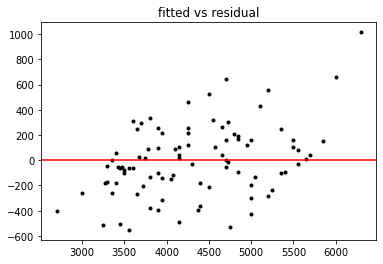

In [43]:
plt.plot(y_train, residuals, '.k')
plt.axhline(0, 0.0, 1.0, color = 'red')
plt.title('fitted vs residual')

`-` 나쁘지 않은 것 같다

`-` 잔차의 히스토그램

<AxesSubplot:>

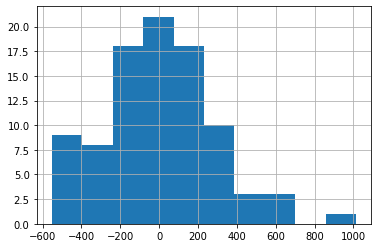

In [44]:
residuals.hist()

`-` 종모양이고 이상점이 있긴한데 개수가 적어서 괜찮은 것 같다

### 라쏘 회귀 최적$\alpha$ 선택

`-` train rmse, test rmse 시각화

In [67]:
train_rmse_list, valid_rmse_list = [], []
alphas = np.linspace(0.01, 0.99, 100)

for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    lasso.fit(x_poly_train_scaled_df, y_train)
    
    train_predict = lasso.predict(x_poly_train_scaled_df) ## 훈련집합 예측
    y_predict = lasso.predict(x_poly_valid_scaled_df) ## valid셋 예측
    
    train_rmse = RMSE(train_predict, y_train)
    valid_rmse = RMSE(y_predict, y_valid)
    train_rmse_list.append(train_rmse)
    valid_rmse_list.append(valid_rmse)

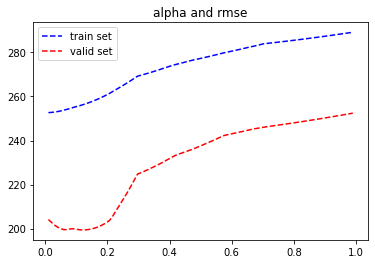

In [71]:
plt.plot(alphas, train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 훈련 집합에 대해서는 $\alpha$가 작을수록 RMSE가 작다

`-` 테스트 집합에 대해서는 $\alpha = 0.1$일 때 RMSE가 가장 작고 증가한다

`-` 최적 $\alpha$값은 $0.7$ 부근인 것 같다(train 그래프와 valid 그래프 사이의 거리가 가장 작은 지점으로 골랐음

## 라쏘 회귀 + 교호작용 + 표준화 + 하이퍼 파라미터 깎기

`-` 어떤 피쳐를 포함하는 것이 좋을지와 $\alpha$를 무엇으로 정할지를 고려하자

`-` 일단 내 생각엔 Full_clutch는 필요없고 Species가 있으면 Island도 필요없다

`-` Species와 Island 둘 다 있으면 과적합이 될 것 같다

`-` 일단 범주형변수와 양적변수사이에 교호작용항을 추가하는 것은 나쁘지 않음

`-` EDA로 보면 큰 차이는 아닌데 범주형변수에 따라 양적변수들의 산점도에서 기울기가 다름

`-` 양적변수와 양적변수사이에 교호작용항을 추가하는 것은 별로라고 생각함

`-` 교호작용이 있다면 기울기가 갑자기 변하는 구간이 있을것인데 그러한 모습은 보이지 않았기 때문(내가 잘못본게 아니라면)

### Full_Clutch와 Island 드랍

In [41]:
x_train2 = x_train.drop(['Full_Clutch', 'Island'], axis = 1)
x_valid2 = x_valid.drop(['Full_Clutch', 'Island'], axis = 1)

`-` 교호작용항을 추가하자

In [42]:
x_poly_train2 = poly(x_train2)
x_poly_valid2 = poly(x_valid2)

In [43]:
## 스케일러 생성
standard_scaler = StandardScaler()

## 트레인집합 정규화
x_poly_train2_scaled = standard_scaler.fit_transform(x_poly_train2)
x_poly_train2_scaled_df = pd.DataFrame(data = x_poly_train2_scaled, columns = x_poly_train2.columns)

## 테스트집합 정규화
x_poly_valid2_scaled = standard_scaler.transform(x_poly_valid2) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용
x_poly_valid2_scaled_df = pd.DataFrame(data = x_poly_valid2_scaled, columns = x_poly_valid2.columns)

`-` $\alpha$ 선택

In [48]:
alphas = [0.3, 0.5, 0.7, 0.9, 5, 10]
for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 20000, random_state = 21)
    lasso.fit(x_poly_train2_scaled_df, y_train)
    y_predict = lasso.predict(x_poly_valid2_scaled_df) ## 모델 예측
    rmse = RMSE(y_predict, y_valid) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.3일 때 이 방정식의 평균 에러는 254.64입니다
𝛼가 0.5일 때 이 방정식의 평균 에러는 257.47입니다
𝛼가 0.7일 때 이 방정식의 평균 에러는 256.63입니다
𝛼가 0.9일 때 이 방정식의 평균 에러는 255.70입니다
𝛼가 5일 때 이 방정식의 평균 에러는 257.75입니다
𝛼가 10일 때 이 방정식의 평균 에러는 257.76입니다


`-` Full_Clutch와 Island 드랍하지 않은 모델과 비교하면 rmse가 더 크다

`-` 하지만 $\alpha$값 변화에 따른 rmse의 변화폭은 훨씩 작기에 일반화 능력은 더 좋은 것 같다

`-` 최적의 $\alpha$값을 선택해보자

In [294]:
train2_rmse_list, valid2_rmse_list = [], []
train2_r2_list, valid2_r2_list = [], []
alphas = np.linspace(0.01, 20, 300)

for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    lasso.fit(x_poly_train2_scaled_df, y_train)
    
    train_predict = lasso.predict(x_poly_train2_scaled_df) ## 훈련집합 예측
    y_predict = lasso.predict(x_poly_valid2_scaled_df) ## valid셋 예측
    
    train_rmse = RMSE(train_predict, y_train) ## rmse
    valid_rmse = RMSE(y_predict, y_valid)
    train2_rmse_list.append(train_rmse)
    valid2_rmse_list.append(valid_rmse)
    
    train_r2 = lasso.score(x_poly_train2_scaled_df, y_train) ## 결정계수(R^2)
    valid_r2 = lasso.score(x_poly_valid2_scaled_df, y_valid)
    train2_r2_list.append(train_r2)
    valid2_r2_list.append(valid_r2)

#### $R^2$ 시각화

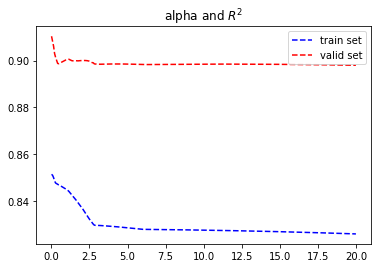

In [295]:
plt.plot(alphas, train2_r2_list, 'b--', label = 'train set')
plt.plot(alphas, valid2_r2_list, 'r--', label = 'valid set')
plt.title('alpha and $R^2$')
plt.legend()

`-` 둘의 $R^2$ 차이가 크다면 오버피팅으로 볼 수 있다

`-` 반대로 차이가 작다면 적합이 잘 되었다고 볼 수 있다

#### RMSE(추정오차의 표준편차) 시각화

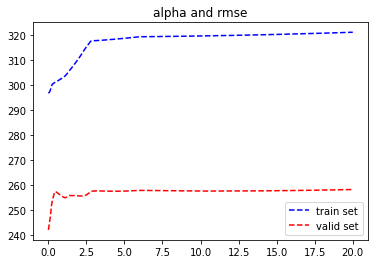

In [296]:
plt.plot(alphas, train2_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, valid2_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 종합해보면 $\alpha = 0.4$일 때가 최적으로 보인다

`-` 정확하게 하자면 $\alpha \approx 0.45545$

`-` 테스트 해봤는데 $\alpha = 0.4$일 때가 제출점수가 더 우수했다

In [926]:
lasso_04 = Lasso(alpha = 0.4, max_iter = 150000, random_state = 21)
lasso_04.fit(x_poly_train2_scaled_df, y_train) ## 라쏘 회귀모형을 train셋을 이용해 학습시킨다

Lasso(alpha=0.4, max_iter=150000, random_state=21)

In [48]:
train_predict = lasso_04.predict(x_poly_train2_scaled_df) ## train셋을 통해 학습된 모델을 통해 train셋을 예측

In [49]:
residuals = y_train - train_predict ## 잔차 = 실제값 - 예측값  

#### 잔차와 적합치 그림

Text(0.5, 1.0, 'fitted vs residual')

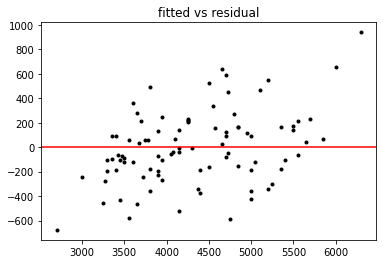

In [42]:
plt.plot(y_train, residuals, '.k')
plt.axhline(0, 0.0, 1.0, color = 'red')
plt.title('fitted vs residual')

`-` 이상점이 하나 있긴 하지만 나쁘지 않은 것 같다

#### 잔차의 히스토그램

<AxesSubplot:>

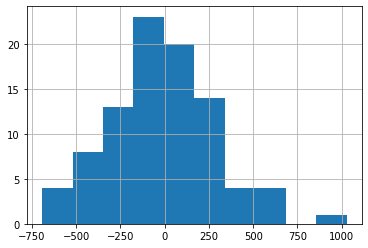

In [49]:
residuals.hist()

`-` 이상점 하나를 제외하면 아름다운 종모양이다

`-` 평균이 $0$이고 표준편차 $250$정도인 정규분포 모양

### stratify 설정 X + Full_Clutch와 Island 드랍 

`-` 내가 stratify를 설정한 이유는 Species 비율을 train과 valid셋이 비슷하도록 하기 위해서였음

`-` 근데 stratify 설정을 안해도 Species 비율이 동일함

`-` stratify를 설정하지 않은 데이터 셋에서도 일반화가 잘 되는지 확인하자

`-` 둘의 차이는 그냥 seed넘버 차이라고 봐도 무방함

`-` 왜 여태까지 $\alpha$를 $1$보다 작게했지...

`-` 참고로 $\alpha=0.8$로 하고 제출했을 때 점수는 267.5501166118 이었다(seed 21)

In [55]:
x_train_raw2 = x_train_raw.copy() 
x_valid_raw2 = x_valid_raw.copy()

In [56]:
x_train_raw3 = x_train_raw2.copy() ## 피쳐 드랍 X 
x_valid_raw3 = x_valid_raw2.copy()

In [57]:
x_train_raw.drop(['Full_Clutch', 'Island'], axis = 1, inplace = True)
x_valid_raw.drop(['Full_Clutch', 'Island'], axis = 1, inplace = True)

In [58]:
x_train_raw2.drop('Full_Clutch', axis = 1, inplace = True)
x_valid_raw2.drop('Full_Clutch', axis = 1, inplace = True)

In [59]:
x_poly_train_raw2 = poly(x_train_raw2)
x_poly_valid_raw2 = poly(x_valid_raw2)

In [60]:
x_poly_train_raw = poly(x_train_raw)
x_poly_valid_raw = poly(x_valid_raw)

In [61]:
## 스케일러 생성
standard_scaler_raw = StandardScaler()

## 트레인집합 정규화
x_poly_train_raw_scaled = standard_scaler_raw.fit_transform(x_poly_train_raw)
x_poly_train_raw_scaled_df = pd.DataFrame(data = x_poly_train_raw_scaled, columns = x_poly_train_raw.columns)

## 테스트집합 정규화
x_poly_valid_raw_scaled = standard_scaler_raw.transform(x_poly_valid_raw) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용
x_poly_valid_raw_scaled_df = pd.DataFrame(data = x_poly_valid_raw_scaled, columns = x_poly_valid_raw.columns)

`-` $\alpha$ 선택

In [227]:
alphas = [0.2, 0.5, 0.8, 1, 5, 10, 15, 20, 30, 40]
for alpha in alphas:
    lasso_raw = Lasso(alpha = alpha, max_iter = 50000, random_state = 21)
    lasso_raw.fit(x_poly_train_raw_scaled_df, y_train_raw)
    y_predict = lasso_raw.predict(x_poly_valid_raw_scaled_df) ## 모델 예측
    rmse = RMSE(y_predict, y_valid_raw) ## 예측값과 실제값을 통해 RMSE를 구함
    print('𝛼가 {}일 때 이 방정식의 평균 에러는 {:.2f}입니다'.format(alpha, rmse))

𝛼가 0.2일 때 이 방정식의 평균 에러는 284.10입니다
𝛼가 0.5일 때 이 방정식의 평균 에러는 285.61입니다
𝛼가 0.8일 때 이 방정식의 평균 에러는 287.09입니다
𝛼가 1일 때 이 방정식의 평균 에러는 288.78입니다
𝛼가 5일 때 이 방정식의 평균 에러는 302.38입니다
𝛼가 10일 때 이 방정식의 평균 에러는 305.60입니다
𝛼가 15일 때 이 방정식의 평균 에러는 307.18입니다
𝛼가 20일 때 이 방정식의 평균 에러는 308.58입니다
𝛼가 30일 때 이 방정식의 평균 에러는 312.73입니다
𝛼가 40일 때 이 방정식의 평균 에러는 318.63입니다


`-` 신기한것이 train과 train_raw의 차이는 seed 뿐인데 RMSE차이가 100까지도 난다(다른 seed로 하면)

`-` 표본 크기가 작기에 그만큼 오버피팅 되거나 언더피팅 되기 쉽다는 의미

`-` 즉 운에 따라 차이가 꽤 있다는 의미

`-` 최적의 $\alpha$값을 선택해보자

In [228]:
train_raw_rmse_list, valid_raw_rmse_list = [], []
train_raw_r2_list, valid_raw_r2_list = [], []
alphas = np.linspace(0.01, 20, 500)

for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    lasso.fit(x_poly_train_raw_scaled_df, y_train_raw)
    
    train_predict = lasso.predict(x_poly_train_raw_scaled_df) ## 훈련집합 예측
    y_predict = lasso.predict(x_poly_valid_raw_scaled_df) ## valid셋 예측
    
    train_rmse = RMSE(train_predict, y_train_raw) ## rmse
    valid_rmse = RMSE(y_predict, y_valid_raw)
    train_raw_rmse_list.append(train_rmse)
    valid_raw_rmse_list.append(valid_rmse)
    
    train_r2 = lasso.score(x_poly_train_raw_scaled_df, y_train_raw) ## 결정계수(R^2)
    valid_r2 = lasso.score(x_poly_valid_raw_scaled_df, y_valid_raw)
    train_raw_r2_list.append(train_r2)
    valid_raw_r2_list.append(valid_r2)

#### $R^2$ 시각화

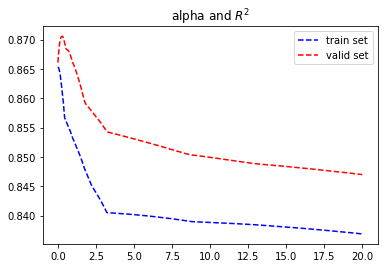

In [229]:
plt.plot(alphas, train_raw_r2_list, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_r2_list, 'r--', label = 'valid set')
plt.title('alpha and $R^2$')
plt.legend()

`-` 그래프가 신기하게 생겼다

`-` $\alpha$가 커질수록 train 셋의 $R^2$은 작아지고 valid 셋의 $R^2$은 커진다

`-` 둘의 $R^2$ 차이가 크다면 오버피팅으로 볼 수 있다

`-` 반대로 차이가 작다면 적합이 잘 되었다고 볼 수 있다

#### RMSE(추정오차의 표준편차) 시각화

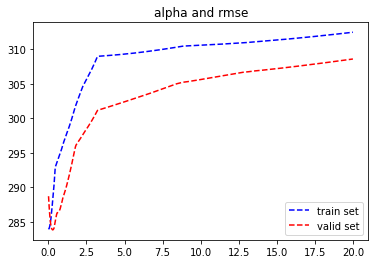

In [230]:
plt.plot(alphas, train_raw_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` stratify 설정을 안했으니 나중에 교차검증도 해보자

## Full_Clutch와 Island 드랍 + 교차검증

`-` 표본 크기가 작은 경우 어떤 표본을 train으로 하고 어떤 표본을 valid로 하냐에 따라 차이가 클 수 있다(위에서 내가 겪음)

`-` 이를 해결하는 방법으로 교차검증이 있는데 표본을 k등분 하고 k-1개의 train과 1개의 valid를 사용해 모델을 평가하는 것

`-` 즉 단순히 train, valid로 나누면 valid는 모델을 훈련시키는데 영영 사용을 못하지만 K fold 방식을 사용하면 훈련 가능

`-` 위에서 train과 valid에 대한 $R^2$이나 rmse를 보면 차이가 심했는데 이는 표본이 어떻게 나뉘는지(운)에 영향을 많이 받아서 그럼

`-` valid 점수가 좋다고 해서 일반화 능력이 항상 좋다고 할 수 없고 valid 셋에 대해 오버피팅 된 것일 수 있다

`-` K fold 방식을 사용해서 일반화 능력을 향상시킬 수 있다

`-` 내가 Full_Clutch와 Island를 드랍했음 ---> Species의 비율이 비슷해야 모델 성능이 잘 나옴

`-` 만약 Species비율이 train, valid와 상이하다면 성능이 안 좋을 수 밖에 없다

`-` EDA를 통해 Species별로 몸무게가 그룹화 되어있음을 알아서 과적합을 막기위해 피쳐2개 버리고 Species만 믿었는데

`-` train, valid비율이 상이하면 뗑컨을 그룹화시킬 피쳐인 Species가 힘을 못 쓴다

`-` Sex 피쳐도 비율이 비슷해야 좋을 것 같은데 이는 내가 특별히 stratify 지정하지 않아도 알아서 분리된다

`-` 교차검증을 통해 최적의 $\alpha$값을 찾아내고 모든 표본을 학습시키자

### Lasso Regressor

In [27]:
from sklearn.model_selection import cross_validate

In [28]:
def get_rmse(neg_mse):
    return np.sqrt(-1*neg_mse)

In [69]:
X_raw = pd.concat([x_poly_train_raw_scaled_df, x_poly_valid_raw_scaled_df]) ## 원래의 target을 제외한 df
target_raw = pd.concat([y_train_raw, y_valid_raw]) ## target

In [70]:
lasso_kfold = Lasso(alpha = 10, max_iter = 200000, random_state = 21)
scores = cross_validate(lasso_kfold, X_raw, target_raw.reset_index().drop('index', axis = 1),
                            scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True, cv = 5)

`-` K겹 교차검증을 통해 최적의 $\alpha$를 찾는다

In [71]:
train_raw_kfold_rmse_list, valid_raw_kfold_rmse_list = [], []
train_raw_kfold_r2_list, valid_raw_kfold_r2_list = [], []
alphas = np.linspace(0.01, 20, 300) ## 알파

for alpha in alphas:
    lasso_kfold = Lasso(alpha = alpha, max_iter = 100000, random_state = 21)
    
    scores = cross_validate(lasso_kfold, X_raw, target_raw.reset_index().drop('index', axis = 1),
                            scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True, cv = 5)

    train_raw_kfold_rmse_list.append(np.mean(list(map(get_rmse, scores['train_neg_mean_squared_error'])))) ## rmse
    valid_raw_kfold_rmse_list.append(np.mean(list(map(get_rmse, scores['test_neg_mean_squared_error']))))

    train_raw_kfold_r2_list.append(np.mean(scores['train_r2'])) ## r2
    valid_raw_kfold_r2_list.append(np.mean(scores['test_r2']))

#### $R^2$ 시각화

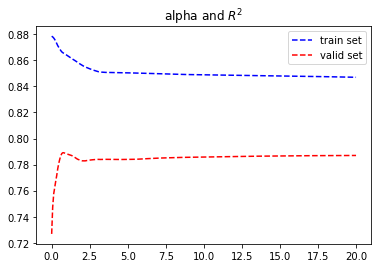

In [37]:
plt.plot(alphas, train_raw_kfold_r2_list, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_r2_list, 'r--', label = 'valid set')
plt.title('alpha and $R^2$')
plt.legend()

`-` $\alpha$가 커질수록 train 셋의 $R^2$은 작아지고 valid 셋의 $R^2$은 커진다

`-` 둘의 $R^2$ 차이가 크다면 오버피팅으로 볼 수 있다

`-` 반대로 차이가 작다면 적합이 잘 되었다고 볼 수 있다

`-` 위의 그래프는 교차검증을 한 모델이므로 일반화 능력이 뛰어나 신뢰가능하다

#### RMSE(추정오차의 표준편차) 시각화

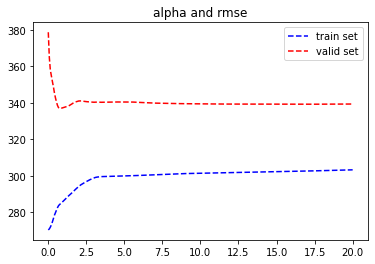

In [73]:
plt.plot(alphas, train_raw_kfold_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

#### 교차검증을 통한 예측

In [74]:
from sklearn.model_selection import StratifiedKFold

In [75]:
Y_raw = pd.concat([y_train_raw, y_valid_raw])

In [76]:
X_poly_raw = pd.concat([x_poly_train_raw, x_poly_valid_raw])

In [77]:
## 스케일러 생성
standard_scaler_all = StandardScaler()

## 전체 데이터셋 정규화
X_poly_raw_scaled = standard_scaler_all.fit_transform(X_poly_raw)
X_poly_raw_scaled_df = pd.DataFrame(data = X_poly_raw_scaled, columns = X_poly_raw.columns)

In [78]:
scaled_raw_df = pd.concat([X_poly_raw_scaled_df, Y_raw.reset_index().drop('index', axis = 1)], axis = 1)

In [79]:
x_poly_raw = scaled_raw_df.copy()
y_raw = scaled_raw_df.copy()

In [80]:
features = x_poly_raw.copy()
features = features.iloc[:,1:]

In [81]:
label = y_raw.copy()
label = label.iloc[:,0]

In [82]:
num_label = label.unique()

In [83]:
num_label

array([ 1.06484795, -0.06966295, -1.20417385])

In [84]:
label.replace(list(num_label), ['a','b','c'], inplace = True)

`-` test 데이터 준비

In [122]:
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/test.csv')

In [123]:
test.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

In [124]:
test['Delta 15 N (o/oo)'].fillna(dt['DeltaN'].median(), inplace = True) ## train셋의 중앙값을 대입
test['Delta 13 C (o/oo)'].fillna(dt['DeltaC'].median(), inplace = True) ## train셋의 중앙값을 대입

In [125]:
test.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 편의상 열 이름 변경

In [126]:
test.loc[[46,81,98,152,205,209], 'Sex'] = ['FEMALE'] * 6 ## train셋과 비교하여 몸무게와 상관관계가 큰 날개 길이가 작아 암컷으로 넣어줌 

In [127]:
test.drop('id', axis = 1, inplace = True) ## id는 필요없으니 드랍

`-` test 셋도 범주형변수에 대해 라벨 인코딩을 해주자

In [91]:
# test2 = test.copy()
# for col in test2.columns:
#     if test2.dtypes[col] == 'O':
#         encoder = LabelEncoder()
#         encoder.fit(test2[col])
#         labels = encoder.transform(test2[col])
#         test2[col] = list(labels) 

`-` 위랑 아래랑 똑같음!

`-` train에서 fit한 라벨인코딩을 사용하여 test셋을 transform하자

In [92]:
test2 = test.copy()

In [93]:
test2.drop(['Island', 'Full_Clutch'], axis = 1, inplace = True)

In [94]:
test_species_labels = species_encoder.transform(test2['Species'])
test2['Species'] = list(test_species_labels) ## Species labelencoding

# test_island_labels = island_encoder.transform(test2['Island'])
# test2['Island'] = list(test_island_labels) ## Island labelencoding

# test_full_clutch_labels = full_clutch_encoder.transform(test2['Full_Clutch'])
# test2['Full_Clutch'] = list(test_full_clutch_labels) ## Full_Clutch labelencoding

test_sex_labels = sex_encoder.transform(test2['Sex'])
test2['Sex'] = list(test_sex_labels) ## Sex labelencoding

In [95]:
test2.head()

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,1,52.0,20.7,210.0,1,9.43146,-24.68440
1,2,55.9,17.0,228.0,1,8.31180,-26.35425
2,0,38.9,18.8,190.0,0,8.36936,-26.11199
3,1,45.2,16.6,191.0,0,9.62357,-24.78984
4,0,37.9,18.6,172.0,0,8.38404,-25.19837


`-` 라벨 인코딩이 잘 되었다

`-` 교호작용항을 추가해주자

In [96]:
test_poly = poly(test2)

In [98]:
test_poly.shape

(228, 17)

`-` 위에서 train셋을 이용해 학습한 스케일러의 평균과 표준편차

In [97]:
## 테스트집합 정규화
test_poly_scaled = standard_scaler_all.transform(test_poly) ## x_train에서 학습한 정규화방식을 그대로 test_poly에 적용
test_poly_scaled_df = pd.DataFrame(data = test_poly_scaled, columns = test_poly.columns)

In [63]:
test_poly_scaled_df.iloc[:6, :6] ## 정규화가 잘 되었는지 확인

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN
0,-0.069663,1.394155,1.906577,0.476205,1.0,1.248586
1,1.064848,2.130221,-0.007715,1.710011,1.0,-0.758321
2,-1.204174,-1.078273,0.923562,-0.894689,-1.0,-0.655149
3,-0.069663,0.110758,-0.214666,-0.826144,-1.0,1.592929
4,-1.204174,-1.267007,0.820087,-2.128494,-1.0,-0.628836
5,-0.069663,1.526270,1.440938,-0.414876,1.0,0.486734


`-` 10개의 각기 다른 train셋으로 훈련시킨 Lasso 모형을 가지고 test셋을 예측해보자

In [165]:
skfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 22)

In [173]:
y_predict5_2 = []
predict_test_2 = []
train_rmse5_2 = []
valid_rmse5_2 = []
lasso_sk = Lasso(alpha = 0.6, max_iter = 50000, random_state = 21) ## 라쏘회귀모형 정의

for train_index, valid_index in skfold.split(features, label):
    ## train, valid 데이터 extract
    xx_train, xx_valid = features.iloc[train_index], features.iloc[valid_index]
    yy_train, yy_valid = label.iloc[train_index], label.iloc[valid_index]

    train_target = xx_train.iloc[:,-1] ## 얘가 진짜 target
    valid_target = xx_valid.iloc[:,-1] ## 얘가 진짜 target
    ori_train = pd.concat([yy_train.replace(['a','b','c'], num_label), xx_train.iloc[:,:-1]], axis = 1) ## 원래의 train feature
    ori_valid = pd.concat([yy_valid.replace(['a','b','c'], num_label), xx_valid.iloc[:,:-1]], axis = 1) ## 원래의 valid feature


    lasso_sk.fit(ori_train, train_target) ## 훈련

    train_predict = lasso_sk.predict(ori_train) ## train셋 예측
    y_predict = lasso_sk.predict(ori_valid) ## valid셋 예측
    test_predict = lasso_sk.predict(test_poly_scaled_df) ## test셋 예측

    y_predict5_2.append(y_predict) ## valid 예측값
    predict_test_2.append(test_predict) ## test 예측값
    train_rmse5_2.append(RMSE(train_predict, train_target)) ## rmse
    valid_rmse5_2.append(RMSE(y_predict, valid_target)) ## rmse

In [174]:
train_rmse5_2, valid_rmse5_2

([281.8518411563329,
  277.73215395013773,
  296.78616825927236,
  297.94411155630274,
  273.94608668880096,
  286.35006254698266,
  289.84874014977555,
  287.4422254485057,
  280.76635961520253,
  291.8217862960949],
 [357.6750506440668,
  422.3514119168324,
  222.2373398407889,
  194.38192114115418,
  459.96735103542426,
  306.69904440072423,
  286.76531847062483,
  321.08022273466025,
  380.3047692863541,
  291.8363817647238])

In [175]:
np.mean(train_rmse5_2), np.mean(valid_rmse5_2)

(286.44895356674084, 324.3298811235354)

In [176]:
sum_ = 0
for i in range(10):
    sum_ += predict_test_2[i]

In [177]:
test_body_mass_predict2 = sum_ / 10

In [178]:
test_body_mass_predict2[:6]

array([4303.33480286, 5565.62974289, 3606.21670031, 3431.91792703,
       3335.77535563, 4180.48051091])

`-` 왜 이런식으로 test 데이터를 예측하는가?

`-` 일단 표본을 train, valid셋으로 나눈다고 해보자

`-` 이는 변동성이 너무 심한다

`-` seed를 어떤 숫자로 하느냐에 따라 모델 성능차이가 꽤 있다(rmse가 100씩 차이 나기도 했음)

`-` 변동성을 줄이고자 앙상블 모델을 만듦 ---> 5개의 릿지회귀모형을 만들고 가중치를 0.2씩 주고 더했다

`-` 피쳐 2개를 제외하기에 Species비율을 train, valid가 비슷하도록 맞춰줬다

`-` 릿지모형의 $\alpha$값은 교차검증을 통해 구했다

`-` 운 좋게 시드넘버 잘 설정해서 test셋 예측에만 최적화된 모형을 만드는건 의미가 없다고 생각함

`-` test셋이 어떠냐에 따라 성능의 변동성이 어마무시한데 모형을 잘 설계했다고 볼 수 있는가?

`-` 그러한 이유로 변동성을 줄이고자 위와 같이 모형을 만들어 test 데이터를 예측함

`-` 물론 5개의 모델을 안 써도 되고 5개 다 동일한 모형이 아니어도 된다

`-` 그냥 편의상 통일함

In [127]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')

In [179]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = test_body_mass_predict2

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4303.334803
1,1,5565.629743
2,2,3606.216700
3,3,3431.917927
4,4,3335.775356


In [129]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_raw_10fold_lasso_0.6.csv', index = False)

`-` 일단 Lasso가 Ridge보다 점수가 더 높게 나왔음

`-` 근데 train셋과 valid셋을 어떻게 나누냐에 따라 같은 모형을 써도 rmse가 다르게 나옴을 알았음

`-` 솔직히 어떤 원인에 의해 차이가 꽤 나는지는 정확히 모름(나중에 EDA 해보자)

`-` train셋에는 이상점 없고 중앙값에 몰려있는 데이터만 있고 valid셋에는 이상점 있으면 점수 낮게 나오겠지

`-` 반대로 train셋에는 이상점있고 valid셋에 이상점 없으면 반대로 점수가 높게 나올 것 임

`-` 다르게 생각하면 5겹 교차검증을 사용함으로써 모델을 공짜로 5개나 만들고

`-` 5개중에서 잘 적합된 모델만 고를 수 있다는 말이다

`-` 중요한 것은 뭐가 좋고 나쁜지 판단 가능하다는 점이다

`-` 그러니 예측점수가 많이 낮은 모델은 쓰지 않고 좋은 모델만 쓰자

`-` 오히려 예측점수가 안좋고 훈련집합에 대한 점수가 좋은 것을 써야되나?

`-` 좀 더 생각해볼 문제임

### 논의

`-` 내가 짜증이 나는 이유는 시드넘버에 따라 모델 성능 차이가 너무 심하기때문 ---> 내가 멍청해서 모델 설계를 못했음

`-` 그래서 교차검증을 했는데 교차검증한 것 끼리도 차이가 많이 난다(첫번째 문장에 의해 당연함)

`-` 하지만 각각 가중치(0.2)를 주고 이들을 합치기 때문에 성능 차이가 조금 줄어든다

`-` 그러면 된 거 아니냐?? 라고 할 수 있지만...

`-` 원래 운으로 때려 맞춘 시드넘버를 가지고 만든 모델읠 점수는 261점이었는걸...

`-` 성능을 더 올리기 위해서는 교차검증 하는데 사용된 모델들 중에서 성능이 더 좋은것을 골라야 함

`-` 그런데 valid 점수가 더 높다고 더 좋은 모델은 아니다

`-` 만약 test case가 train 셋에서 많이 나온다면 오히려 train 점수가 더 높은 모델이 더 좋다!

`-` 그런데 나는 그걸 모른다

`-` 그래서 짜증이 난다

`-` 그래서 생각한 것이 최적의 $\alpha$값만 찾아내고 학습 데이터로 주어진 표본을 전부 사용하는 방법이다

`-` 이러면 위와 같이 짜증낼 필요가 없다

`-` 왜냐면 학습 데이터는 어떤 모형이든지 똑같으니까!

`-` 하지만 최적의 $\alpha$값을 찾을려면 train, valid로 나눠야 되므로 

`-` train + valid로 학습시키는 모델의 최적 $\alpha$값과 동일하진 않을 것이다(또한 나는 바보라서 최적의 $\alpha$ 기준을 모른다)

`-` 그래도 짜증낼 필요는 없어지니 위와 같은 방법을 고려하는 것도 나쁘지 않은 선택같다

`-` 아니면 Species별로 모델을 3개를 만들자(이때는 Full_Clutch만 drop하고 Island를 drop하면 안된다) ---> 근데 귀찮음

`-` 아니면 붓스트랩 표본을 만들어서 표본 크기를 늘리는 것도 있긴한데 이를 구현할 능력이 되지 않는다

`-` 일단 데이터별 가중치도 다르게 줘야 되는데 중앙값 근처의 값이 이상값보다 뽑힐 가능성이 더 높다(아님말고)

`-` 마치 원에 점을 무작위로 뿌리면 중앙에 점이 더 몰리듯이

`-` 결론 : 나의 두뇌로는 표본 전부를 학습시키는데 쓰고 어떤 모델을 쓸지와 하이퍼 파라미터를 무엇으로 정할지 까지가 한계이다 

`-` 이 이상의 두뇌를 요구하는 구현은 못함

`-` 일단 내가 모르고 있던 사실이 있었는데 모형에 데이터를 fit 시키는 것은 누적된다(아님말고)

`-` 즉 한번 fit시키고 다른 데이터로 fit시킨다고 기존의 fit시켜서 학습한 것이 사라지지 않고 누적된다는 것

`-` 초기화 되는줄...

`-` 그러니 다섯번 fit 시킨 모델을 가지고 test 셋을 예측하면 된다

`-` 응 초기화 돼^^

`-` 애초애 초기화 안되면 중복학습을 하게 된다

`-` 그냥 교차검증의 valid 셋에 대한 평균 rmse를 일반화 능력이라 평가해야 겠다 

### Ridge Regressor

`-` train, valid가 어떻게 나뉘냐에 따라 차이가 심하니 라쏘보다는 릿지가 나을 수 도 있다

`-` 릿지 모형을 사용해보자

In [182]:
train_raw_kfold_rmse_list2, valid_raw_kfold_rmse_list2 = [], []
train_raw_kfold_r2_list2, valid_raw_kfold_r2_list2 = [], []
alphas = np.linspace(0.01, 20, 300)

for alpha in alphas:
    ridge_kfold = Ridge(alpha = alpha, max_iter = 100000, random_state = 21)
    scores = cross_validate(ridge_kfold, X_raw, target_raw.reset_index().drop('index', axis = 1),
                            scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True, cv = 5)
    
    train_raw_kfold_rmse_list2.append(np.mean(list(map(get_rmse, scores['train_neg_mean_squared_error'])))) ## rmse
    valid_raw_kfold_rmse_list2.append(np.mean(list(map(get_rmse, scores['test_neg_mean_squared_error']))))
    
    train_raw_kfold_r2_list2.append(np.mean(scores['train_r2'])) ## r2
    valid_raw_kfold_r2_list2.append(np.mean(scores['test_r2']))

#### $R^2$ 시각화

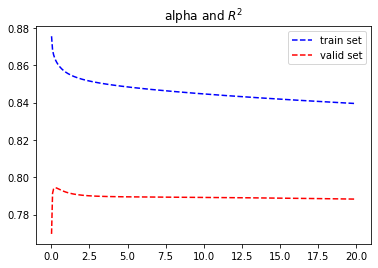

In [288]:
plt.plot(alphas, train_raw_kfold_r2_list2, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_r2_list2, 'r--', label = 'valid set')
plt.title('alpha and $R^2$')
plt.legend()

#### RMSE(추정오차의 표준편차) 시각화

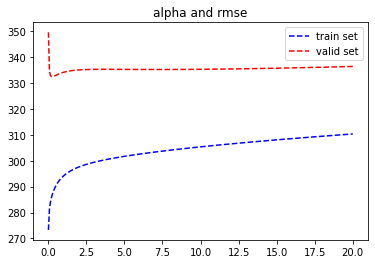

In [289]:
plt.plot(alphas, train_raw_kfold_rmse_list2, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_rmse_list2, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 릿지 회귀모형이 라쏘 회귀모형보다 더 나아보인다

`-` 근데 사실 문제점이 하나 있다

`-` train 셋에 스케일링을 fit하고 변환시켰다

`-` valid 셋은 변환만 시켰다

`-` 그리고 이 둘을 합쳐서 데이터프레임으로 만들고 교차검증을 했다

`-` train, valid가 무작위로 나뉘는데 나뉠때마다 스케일링을 새로 해야한다

`-` 근데 이렇게 하기 귀찮다...

`-` 그냥 train, valid 합쳐서 스케일링을 하자

`-` 그만큼 test 셋에 대한 일반화는 조금 떨어지겠지만 큰 문제는 없을 것이다

`-` 또 문제는 표본 크기가 작아 train, valid를 어떻게 나누냐에 따라 차이가 크다는 것이다

`-` 물론 교차검증하니 그렇지 않을 때보단 낫겠지만 그래도 차이가 존재한다

`-` Species 변수를 비슷한 비율로 나눔으로써 차이를 적게 해보자

`-` 5개의 각기 다른 train셋으로 훈련시킨 Ridge 모형을 가지고 test셋을 예측해보자

In [203]:
y_predict5 = []
predict_test = []
train_rmse5 = []
valid_rmse5 = []

for train_index, valid_index in skfold.split(features, label):
    ## train, valid 데이터 extract
    xx_train, xx_valid = features.iloc[train_index], features.iloc[valid_index]
    yy_train, yy_valid = label.iloc[train_index], label.iloc[valid_index]
    
    train_target = xx_train.iloc[:,-1] ## 얘가 진짜 target
    valid_target = xx_valid.iloc[:,-1] ## 얘가 진짜 target
    ori_train = pd.concat([yy_train.replace(['a','b','c'], num_label), xx_train.iloc[:,:-1]], axis = 1) ## 원래의 train feature
    ori_valid = pd.concat([yy_valid.replace(['a','b','c'], num_label), xx_valid.iloc[:,:-1]], axis = 1) ## 원래의 valid feature
    
    ridge = Ridge(alpha = 0.7, max_iter = 50000, random_state = 21)
    ridge.fit(ori_train, train_target) ## 훈련
    
    train_predict = ridge.predict(ori_train) ## train셋 예측
    y_predict = ridge.predict(ori_valid) ## valid셋 예측
    test_predict = ridge.predict(test_poly_scaled_df) ## test셋 예측
    
    y_predict5.append(y_predict) ## valid 예측값
    predict_test.append(test_predict) ## test 예측값
    train_rmse5.append(RMSE(train_predict, train_target)) ## rmse
    valid_rmse5.append(RMSE(y_predict, valid_target)) ## rmse

In [204]:
np.mean(train_rmse5), np.mean(valid_rmse5)

(294.1149541952947, 319.2451370339959)

In [205]:
sum_ = 0
for i in range(10):
    sum_ += predict_test[i]

In [206]:
test_body_mass_predict = sum_ / 10

In [207]:
test_body_mass_predict[:6]

array([4358.25052519, 5513.42078129, 3596.80613331, 3468.80666937,
       3268.34843028, 4212.06403313])

In [208]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')

In [209]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = test_body_mass_predict

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4358.250525
1,1,5513.420781
2,2,3596.806133
3,3,3468.806669
4,4,3268.348430


In [210]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_raw_10fold_ridge_0.7.csv', index = False)

## Full_Clutch 드랍

In [404]:
x_train3 = x_train.drop('Full_Clutch', axis = 1)
x_valid3 = x_valid.drop('Full_Clutch', axis = 1)

`-` 교호작용항을 추가하자

In [405]:
x_poly_train3 = poly(x_train3)
x_poly_valid3 = poly(x_valid3)

In [406]:
## 스케일러 생성
standard_scaler = StandardScaler()

## 트레인집합 정규화
x_poly_train3_scaled = standard_scaler.fit_transform(x_poly_train3)
x_poly_train3_scaled_df = pd.DataFrame(data = x_poly_train3_scaled, columns = x_poly_train3.columns)

## 테스트집합 정규화
x_poly_valid3_scaled = standard_scaler.transform(x_poly_valid3) ## x_train에서 학습한 정규화방식을 그대로 x_valid에 적용
x_poly_valid3_scaled_df = pd.DataFrame(data = x_poly_valid3_scaled, columns = x_poly_valid3.columns)

`-` 최적의 $\alpha$값을 선택해보자

In [408]:
train3_rmse_list, valid3_rmse_list = [], []
train3_r2_list, valid3_r2_list = [], []
alphas = np.linspace(0.01, 1, 100)

for alpha in alphas:
    lasso = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    lasso.fit(x_poly_train3_scaled_df, y_train)
    
    train_predict = lasso.predict(x_poly_train3_scaled_df) ## 훈련집합 예측
    y_predict = lasso.predict(x_poly_valid3_scaled_df) ## valid셋 예측
    
    train_rmse = RMSE(train_predict, y_train) ## rmse
    valid_rmse = RMSE(y_predict, y_valid)
    train3_rmse_list.append(train_rmse)
    valid3_rmse_list.append(valid_rmse)
    
    train_r2 = lasso.score(x_poly_train3_scaled_df, y_train) ## R^2
    valid_r2 = lasso.score(x_poly_valid3_scaled_df, y_valid)
    train3_r2_list.append(train_r2)
    valid3_r2_list.append(valid_r2)

`-` 결정계수 시각화

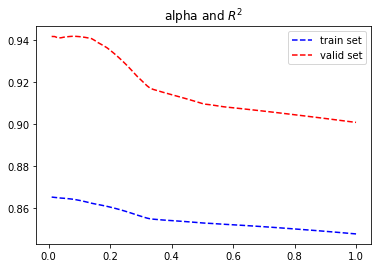

In [409]:
plt.plot(alphas, train3_r2_list, 'b--', label = 'train set')
plt.plot(alphas, valid3_r2_list, 'r--', label = 'valid set')
plt.title('alpha and $R^2$')
plt.legend()

`-` RMSE(추정오차의 표준편차) 시각화

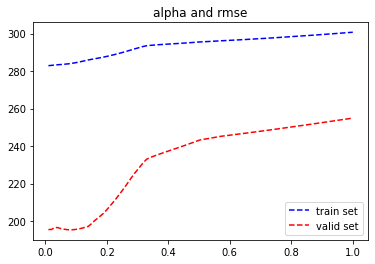

In [410]:
plt.plot(alphas, train3_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, valid3_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 변수를 드랍하지 않고 라쏘 회귀를 돌린 모형과 비슷한 그래프를 보인다

`-` $\alpha = 0.7$일 때가 최적으로 보인다

### 교호작용 + 교차검증

`-` 라쏘 회귀 사용함

In [206]:
Y_raw = pd.concat([y_train_raw, y_valid_raw])

In [207]:
X_poly_raw2 = pd.concat([x_poly_train_raw2, x_poly_valid_raw2])

In [208]:
## 스케일러 생성
standard_scaler_raw2 = StandardScaler()

## 전체 데이터셋 정규화
X_poly_raw_scaled2 = standard_scaler_raw2.fit_transform(X_poly_raw2)
X_poly_raw_scaled_df2 = pd.DataFrame(data = X_poly_raw_scaled2, columns = X_poly_raw2.columns)

In [209]:
scaled_raw_df2 = pd.concat([X_poly_raw_scaled_df2, Y_raw.reset_index().drop('index', axis = 1)], axis = 1) ## 왜 합쳤지?

In [218]:
train_raw_kfold_rmse_list3, valid_raw_kfold_rmse_list3 = [], []
train_raw_kfold_r2_list3, valid_raw_kfold_r2_list3 = [], []
alphas = np.linspace(0.01, 20, 300)

for alpha in alphas:
    lasso3 = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    scores = cross_validate(lasso3, X_poly_raw_scaled_df2, Y_raw.reset_index().drop('index', axis = 1),
                            scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True, cv = 5)
    
    train_raw_kfold_rmse_list3.append(np.mean(list(map(get_rmse, scores['train_neg_mean_squared_error'])))) ## rmse
    valid_raw_kfold_rmse_list3.append(np.mean(list(map(get_rmse, scores['test_neg_mean_squared_error']))))
    
    train_raw_kfold_r2_list3.append(np.mean(scores['train_r2'])) ## r2
    valid_raw_kfold_r2_list3.append(np.mean(scores['test_r2']))

#### $R^2$ 시각화

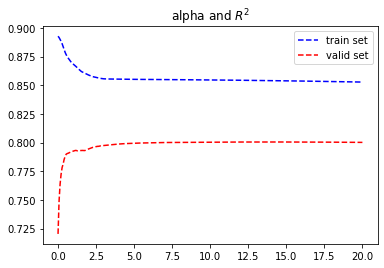

In [219]:
plt.plot(alphas, train_raw_kfold_r2_list3, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_r2_list3, 'r--', label = 'valid set')
plt.title('alpha and $R^2$')
plt.legend()

#### RMSE(추정오차의 표준편차) 시각화

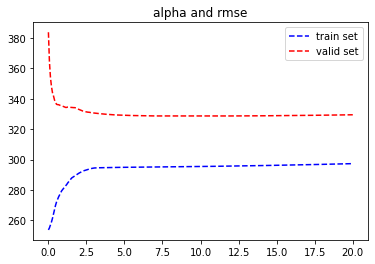

In [220]:
plt.plot(alphas, train_raw_kfold_rmse_list3, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_rmse_list3, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 릿지 회귀

In [221]:
train_raw_kfold_rmse_list4, valid_raw_kfold_rmse_list4 = [], []
train_raw_kfold_r2_list4, valid_raw_kfold_r2_list4 = [], []
alphas = np.linspace(0.01, 20, 300)

for alpha in alphas:
    ridge3 = Ridge(alpha = alpha, max_iter = 150000, random_state = 21)
    scores = cross_validate(ridge3, X_poly_raw_scaled_df2, Y_raw.reset_index().drop('index', axis = 1),
                            scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True, cv = 5)
    
    train_raw_kfold_rmse_list4.append(np.mean(list(map(get_rmse, scores['train_neg_mean_squared_error'])))) ## rmse
    valid_raw_kfold_rmse_list4.append(np.mean(list(map(get_rmse, scores['test_neg_mean_squared_error']))))
    
    train_raw_kfold_r2_list4.append(np.mean(scores['train_r2'])) ## r2
    valid_raw_kfold_r2_list4.append(np.mean(scores['test_r2']))

#### $R^2$ 시각화

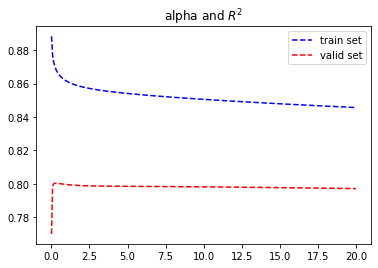

In [222]:
plt.plot(alphas, train_raw_kfold_r2_list4, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_r2_list4, 'r--', label = 'valid set')
plt.title('alpha and $R^2$')
plt.legend()

#### RMSE(추정오차의 표준편차) 시각화

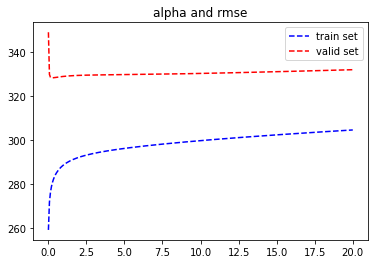

In [223]:
plt.plot(alphas, train_raw_kfold_rmse_list4, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_rmse_list4, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

### 교차검증

`-` 교호작용 생략하고 교차검증만 수행

In [228]:
x_raw3 = pd.concat([x_train_raw2, x_valid_raw2])

In [234]:
Y_raw.head()

85    5550
98    5500
69    5350
0     5550
22    4650
Name: Body_Mass, dtype: int64

In [235]:
## 스케일러 생성
standard_scaler_raw3 = StandardScaler()

## 전체 데이터셋 정규화
X_raw_scaled3 = standard_scaler_raw3.fit_transform(x_raw3)
X_raw_scaled_df3 = pd.DataFrame(data = X_raw_scaled3, columns = x_raw3.columns)

In [237]:
X_raw_scaled_df3.head()

,Species,Island,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,1.064848,-0.900401,0.827950,-0.473354,0.887474,1.0,-1.130483,0.264430
1,1.064848,-0.900401,0.846824,-1.042468,1.710011,1.0,-0.135740,-0.074362
2,1.064848,-0.900401,1.016685,-0.576829,1.435832,1.0,-0.957962,-0.789703
3,1.064848,-0.900401,1.016685,-0.887255,1.161653,1.0,-0.770241,0.637574
4,1.064848,-0.900401,-0.210092,-0.938992,0.681840,-1.0,-0.929426,-0.451030


`-` 라쏘 회귀

In [238]:
train_raw_kfold_rmse_list5, valid_raw_kfold_rmse_list5 = [], []
train_raw_kfold_r2_list5, valid_raw_kfold_r2_list5 = [], []
alphas = np.linspace(0.01, 20, 300)

for alpha in alphas:
    lasso4 = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    scores = cross_validate(lasso4, X_raw_scaled_df3, Y_raw.reset_index().drop('index', axis = 1),
                            scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True, cv = 5)
    
    train_raw_kfold_rmse_list5.append(np.mean(list(map(get_rmse, scores['train_neg_mean_squared_error'])))) ## rmse
    valid_raw_kfold_rmse_list5.append(np.mean(list(map(get_rmse, scores['test_neg_mean_squared_error']))))
    
    train_raw_kfold_r2_list5.append(np.mean(scores['train_r2'])) ## r2
    valid_raw_kfold_r2_list5.append(np.mean(scores['test_r2']))

#### $R^2$ 시각화

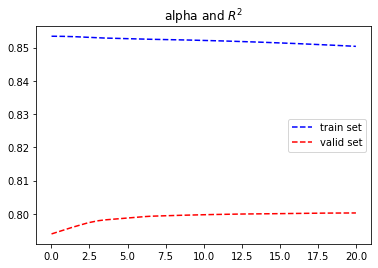

In [239]:
plt.plot(alphas, train_raw_kfold_r2_list5, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_r2_list5, 'r--', label = 'valid set')
plt.title('alpha and $R^2$')
plt.legend()

#### RMSE(추정오차의 표준편차) 시각화

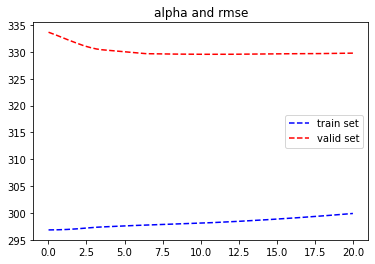

In [240]:
plt.plot(alphas, train_raw_kfold_rmse_list5, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_rmse_list5, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 릿지 회귀

In [241]:
train_raw_kfold_rmse_list6, valid_raw_kfold_rmse_list6 = [], []
train_raw_kfold_r2_list6, valid_raw_kfold_r2_list6 = [], []
alphas = np.linspace(0.01, 20, 300)

for alpha in alphas:
    ridge4 = Ridge(alpha = alpha, max_iter = 150000, random_state = 21)
    scores = cross_validate(ridge4, X_raw_scaled_df3, Y_raw.reset_index().drop('index', axis = 1),
                            scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True, cv = 5)
    
    train_raw_kfold_rmse_list6.append(np.mean(list(map(get_rmse, scores['train_neg_mean_squared_error'])))) ## rmse
    valid_raw_kfold_rmse_list6.append(np.mean(list(map(get_rmse, scores['test_neg_mean_squared_error']))))
    
    train_raw_kfold_r2_list6.append(np.mean(scores['train_r2'])) ## r2
    valid_raw_kfold_r2_list6.append(np.mean(scores['test_r2']))

#### $R^2$ 시각화

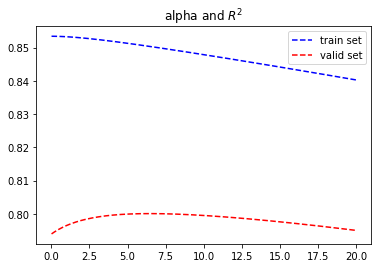

In [242]:
plt.plot(alphas, train_raw_kfold_r2_list6, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_r2_list6, 'r--', label = 'valid set')
plt.title('alpha and $R^2$')
plt.legend()

#### RMSE(추정오차의 표준편차) 시각화

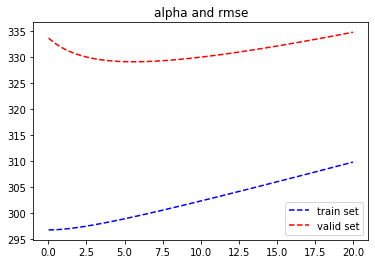

In [243]:
plt.plot(alphas, train_raw_kfold_rmse_list6, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_kfold_rmse_list6, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 성능은 라쏘 > 릿지 > 엘라스틱 넷

### test 예측

`-` 성능이 가장 좋게 나온 라쏘 회귀 모형을 통해 test 데이터를 예측하자

`-` Full_Clutch와 Island를 드랍하고 교호작용을 추가한 데이터를 사용하자

`-` $\alpha = 0.4$인 라쏘 모델을 사용하자

In [222]:
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/test.csv')
test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [223]:
test.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

In [224]:
test['Delta 15 N (o/oo)'].fillna(dt['DeltaN'].median(), inplace = True) ## train셋의 중앙값을 대입
test['Delta 13 C (o/oo)'].fillna(dt['DeltaC'].median(), inplace = True) ## train셋의 중앙값을 대입

In [225]:
test.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 편의상 열 이름 변경

In [226]:
test.loc[[46,81,98,152,205,209], 'Sex'] = ['FEMALE'] * 6 ## train셋과 비교하여 몸무게와 상관관계가 큰 날개 길이가 작아 암컷으로 넣어줌 

In [227]:
test.drop('id', axis = 1, inplace = True) ## id는 필요없으니 드랍

`-` test 셋도 범주형변수에 대해 라벨 인코딩을 해주자

In [933]:
# test2 = test.copy()
# for col in test2.columns:
#     if test2.dtypes[col] == 'O':
#         encoder = LabelEncoder()
#         encoder.fit(test2[col])
#         labels = encoder.transform(test2[col])
#         test2[col] = list(labels) 

`-` 위랑 아래랑 똑같음!

`-` train에서 fit한 라벨인코딩을 사용하여 test셋을 transform하자

In [228]:
test2 = test.copy()

In [229]:
test2.drop(['Island', 'Full_Clutch'], axis = 1, inplace = True)

In [230]:
test_species_labels = species_encoder.transform(test2['Species'])
test2['Species'] = list(test_species_labels) ## Species labelencoding

# test_island_labels = island_encoder.transform(test2['Island'])
# test2['Island'] = list(test_island_labels) ## Island labelencoding

# test_full_clutch_labels = full_clutch_encoder.transform(test2['Full_Clutch'])
# test2['Full_Clutch'] = list(test_full_clutch_labels) ## Full_Clutch labelencoding

test_sex_labels = sex_encoder.transform(test2['Sex'])
test2['Sex'] = list(test_sex_labels) ## Sex labelencoding

In [231]:
test2.head()

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,1,52.0,20.7,210.0,1,9.43146,-24.68440
1,2,55.9,17.0,228.0,1,8.31180,-26.35425
2,0,38.9,18.8,190.0,0,8.36936,-26.11199
3,1,45.2,16.6,191.0,0,9.62357,-24.78984
4,0,37.9,18.6,172.0,0,8.38404,-25.19837


`-` 라벨 인코딩이 잘 되었다

`-` 교호작용항을 추가해주자

In [278]:
test_poly = poly(test2)

In [310]:
test_poly.shape

(228, 17)

`-` 위에서 train셋을 이용해 학습한 스케일러의 평균과 표준편차

In [311]:
## 테스트집합 정규화
test_poly_scaled = standard_scaler.transform(test_poly) ## x_train에서 학습한 정규화방식을 그대로 test_poly에 적용
test_poly_scaled_df = pd.DataFrame(data = test_poly_scaled, columns = test_poly.columns)

In [281]:
test_poly_scaled_df.iloc[:6, :6] ## 정규화가 잘 되었는지 확인

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN
0,-0.062325,1.491127,1.763502,0.529023,1.033529,1.256334
1,1.071989,2.249948,-0.031453,1.774052,1.033529,-0.757531
2,-1.196639,-1.057730,0.841768,-0.854342,-0.967559,-0.654001
3,-0.062325,0.168057,-0.225502,-0.785174,-0.967559,1.601870
4,-1.196639,-1.252299,0.744744,-2.099371,-0.967559,-0.627597
5,-0.062325,1.627326,1.326891,-0.370164,1.033529,0.491840


`-` 이제 예측을 하자

In [942]:
predict_test = lasso_04.predict(test_poly_scaled_df) ## train셋을 통해 학습된 모델을 통해 test셋을 예측

# 예측 결과를 확인
predict_test[:6]

array([4292.43478938, 5644.7010042 , 3629.57759285, 3398.53498446,
       3355.05669231, 4143.32128426])

`-` 피쳐네임과 회귀계수 값을 함께 봐보자

In [830]:
list(zip(test_poly_scaled_df, lasso_04.coef_))

[('Species', 0.0),
 ('Culmen_Length', 24.848732652465234),
 ('Culmen_Depth', 79.43041730143314),
 ('Flipper_Length', 146.63116217098397),
 ('Sex', 443.64801316387513),
 ('DeltaN', -66.56675817740579),
 ('DeltaC', -71.17941002407247),
 ('Species_Culmen_Length', 568.1609963555894),
 ('Species_Culmen_Depth', -214.64866329946864),
 ('Species_Flipper_Length', 1217.2231087830062),
 ('Species_DeltaN', -1111.6009737482907),
 ('Species_DeltaC', -0.0),
 ('Sex_Culmen_Length', -427.40110849530294),
 ('Sex_Culmen_Depth', -22.150135494133274),
 ('Sex_Flipper_Length', 208.7342952529078),
 ('Sex_DeltaN', -0.0),
 ('Sex_DeltaC', -0.0)]

### dacon 대회에 제출하기

In [388]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')

In [948]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = predict_test

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4292.434789
1,1,5644.701004
2,2,3629.577593
3,3,3398.534984
4,4,3355.056692


In [390]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_04.csv', index = False)

`-` 점수는 261.4589133342

`-` 근데 내가 test셋 방사성 동위원소 결측치를 중앙값으로 채워야되는데 평균으로 채웠음

`-` 중앙값으로 채운것은 점수가 위와 다르겠지만 큰 차이는 없을 듯

`-` 일단 EDA를 통해 Full_Clutch는 유의미하지 않은 것을 확인했다

`-` 그리고 Species와 Island 각각에 대해서 뗑컨 피쳐들의 산점도가 그룹화 되어있었다 

`-` 이를 보고 Species와 Island 둘 중 하나만 피쳐로 사용하는 것이 좋다고 생각했고

`-` 직관적으로 보기엔 Island보다 Speices가 뗑컨 몸무게와 더 관련있다 생각했다

`-` Island와 뗑컨 몸무게 사이에는 중첩 변수가 존재한다고 생각했음

`-` 아무튼 그래서 Island와 Full_Clutch를 제거했는데 일반화능력이 그렇지 않은 것보다 좋게 나왔다

## 교호작용항 세심하게 만들기

`-` 교호작용항을 만들 때 그냥 범주형 변수와 양적 변수끼리 만들었는데 유용한 피쳐만 골라서 만들겠다

`-` 이는 EDA를 통해 몸무게와 다른 양적 변수와의 산점도에서 범주형 변수별 나타나는 기울기의 차이를 통해 구분했다

`-` 그리고 Island와 Full_Cluthch는 주관적인 이유로 교호작용항으로 만들지 않을 것이다(그냥 만들까?)

`-` 다양하게 만들어보자

In [46]:
x_train_raw.head()

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
85,2,0,0,49.0,16.1,216,1,8.10417,-25.50562
98,2,0,1,49.1,15.0,228,1,8.65914,-25.79203
69,2,0,1,50.0,15.9,224,1,8.20042,-26.39677
0,2,0,1,50.0,15.3,220,1,8.30515,-25.19017
22,2,0,1,43.5,15.2,213,0,8.21634,-26.11046


In [57]:
raw_x = dt.copy()

In [58]:
raw_x.drop(['Island', 'Full_Clutch'], axis = 1, inplace = True)

`-` 교호작용 추가

In [59]:
raw_x['Sex_DeltaN'] = raw_x['Sex'] * raw_x['DeltaN']

raw_x['Species_DeltaN'] = raw_x['Species'] * raw_x['DeltaN']
raw_x['Species_Culmen_Depth'] = raw_x['Species'] * raw_x['Culmen_Depth']
raw_x['Species_Flipper_Length'] = raw_x['Species'] * raw_x['Flipper_Length']

In [60]:
raw_x.head()

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Sex_DeltaN,Species_DeltaN,Species_Culmen_Depth,Species_Flipper_Length
0,2,50.0,15.3,220,1,8.30515,-25.19017,8.30515,16.61030,30.6,440
1,1,49.5,19.0,200,1,9.63074,-24.34684,9.63074,9.63074,19.0,200
2,2,45.1,14.4,210,0,8.51951,-27.01854,0.00000,17.03902,28.8,420
3,2,44.5,14.7,214,0,8.20106,-26.16524,0.00000,16.40212,29.4,428
4,2,49.6,16.0,225,1,8.38324,-26.84272,8.38324,16.76648,32.0,450


`-` 표준화를 해주자

In [61]:
## 스케일러 생성
my_scaler = StandardScaler()

## 전체 데이터셋 정규화
my_scaled = my_scaler.fit_transform(raw_x)
my_scaled_df = pd.DataFrame(data = my_scaled, columns = raw_x.columns)

In [254]:
test = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/test.csv')
test.head()

,id,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,0,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,52.0,20.7,210.0,MALE,9.43146,-24.68440
1,1,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,55.9,17.0,228.0,MALE,8.31180,-26.35425
2,2,Adelie Penguin (Pygoscelis adeliae),Dream,Yes,38.9,18.8,190.0,FEMALE,8.36936,-26.11199
3,3,Chinstrap penguin (Pygoscelis antarctica),Dream,Yes,45.2,16.6,191.0,FEMALE,9.62357,-24.78984
4,4,Adelie Penguin (Pygoscelis adeliae),Biscoe,No,37.9,18.6,172.0,FEMALE,8.38404,-25.19837


In [255]:
test.isnull().sum()

id                     0
Species                0
Island                 0
Clutch Completion      0
Culmen Length (mm)     0
Culmen Depth (mm)      0
Flipper Length (mm)    0
Sex                    6
Delta 15 N (o/oo)      9
Delta 13 C (o/oo)      8
dtype: int64

In [256]:
test['Delta 15 N (o/oo)'].fillna(dt['DeltaN'].median(), inplace = True) ## train셋의 중앙값을 대입
test['Delta 13 C (o/oo)'].fillna(dt['DeltaC'].median(), inplace = True) ## train셋의 중앙값을 대입

In [257]:
test.rename(columns = {'Clutch Completion':'Full_Clutch', 'Culmen Length (mm)':'Culmen_Length', 
                     'Culmen Depth (mm)':'Culmen_Depth', 'Flipper Length (mm)':'Flipper_Length',
                     'Delta 15 N (o/oo)':'DeltaN', 'Delta 13 C (o/oo)':'DeltaC', 'Body Mass (g)':'Body_Mass'}, inplace = True) ## 편의상 열 이름 변경

In [258]:
test.loc[[46,81,98,152,205,209], 'Sex'] = ['FEMALE'] * 6 ## train셋과 비교하여 몸무게와 상관관계가 큰 날개 길이가 작아 암컷으로 넣어줌 

In [259]:
test.drop('id', axis = 1, inplace = True) ## id는 필요없으니 드랍

`-` test 셋도 범주형변수에 대해 라벨 인코딩을 해주자

In [933]:
# test2 = test.copy()
# for col in test2.columns:
#     if test2.dtypes[col] == 'O':
#         encoder = LabelEncoder()
#         encoder.fit(test2[col])
#         labels = encoder.transform(test2[col])
#         test2[col] = list(labels) 

`-` 위랑 아래랑 똑같음!

`-` train에서 fit한 라벨인코딩을 사용하여 test셋을 transform하자

In [128]:
test3 = test.copy()

In [129]:
test3.drop(['Island', 'Full_Clutch'], axis = 1, inplace = True)

In [130]:
test_species_labels = species_encoder.transform(test3['Species'])
test3['Species'] = list(test_species_labels) ## Species labelencoding

# test_island_labels = island_encoder.transform(test2['Island'])
# test2['Island'] = list(test_island_labels) ## Island labelencoding

# test_full_clutch_labels = full_clutch_encoder.transform(test2['Full_Clutch'])
# test2['Full_Clutch'] = list(test_full_clutch_labels) ## Full_Clutch labelencoding

test_sex_labels = sex_encoder.transform(test3['Sex'])
test3['Sex'] = list(test_sex_labels) ## Sex labelencoding

In [131]:
test3.head()

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,1,52.0,20.7,210.0,1,9.43146,-24.68440
1,2,55.9,17.0,228.0,1,8.31180,-26.35425
2,0,38.9,18.8,190.0,0,8.36936,-26.11199
3,1,45.2,16.6,191.0,0,9.62357,-24.78984
4,0,37.9,18.6,172.0,0,8.38404,-25.19837


`-` 라벨 인코딩이 잘 되었다

`-` 교호작용항을 추가해주자

In [242]:
test3['Sex_DeltaN'] = test3['Sex'] * test3['DeltaN']

test3['Species_DeltaN'] = test3['Species'] * test3['DeltaN']
test3['Species_Culmen_Depth'] = test3['Species'] * test3['Culmen_Depth']
test3['Species_Flipper_Length'] = test3['Species'] * test3['Flipper_Length']

In [243]:
test3.shape

(228, 11)

`-` 위에서 train셋을 이용해 학습한 스케일러의 평균과 표준편차

In [247]:
## 테스트집합 정규화
test3_scaled = my_scaler.transform(test3) ## x_train에서 학습한 정규화방식을 그대로 test_poly에 적용
test3_scaled_df = pd.DataFrame(data = test3_scaled, columns = test3.columns)

In [249]:
test3_scaled_df.head() ## 정규화가 잘 되었는지 확인

,Species,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Sex_DeltaN,Species_DeltaN,Species_Culmen_Depth,Species_Flipper_Length
0,-0.069663,1.394155,1.906577,0.476205,1.0,1.248586,1.235845,1.135290,0.054321,0.291266,-0.086430
1,1.064848,2.130221,-0.007715,1.710011,1.0,-0.758321,-0.739407,0.882213,1.039447,1.281218,1.187935
2,-1.204174,-1.078273,0.923562,-0.894689,-1.0,-0.655149,-0.452839,-0.996506,-1.237531,-1.249486,-1.174303
3,-0.069663,0.110758,-0.214666,-0.826144,-1.0,1.592929,1.111120,-0.996506,0.080635,-0.013907,-0.184857
4,-1.204174,-1.267007,0.820087,-2.128494,-1.0,-0.628836,0.627874,-0.996506,-1.237531,-1.249486,-1.174303


In [29]:
from sklearn.model_selection import KFold

In [37]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 22)

### 라쏘 회귀

`-` 라쏘 회귀의 $\alpha$ 선택 ---> $\alpha = 27$이 좋아보임

In [62]:
train_raw_rmse, valid_raw_rmse = [], []
train_raw_r2, valid_raw_r2 = [], []
alphas = np.linspace(0.01, 50, 300)

for alpha in alphas:
    my_lasso = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    scores = cross_validate(my_lasso, my_scaled_df, target,
                            scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True, cv = kfold)
    
    train_raw_rmse.append(np.mean(list(map(get_rmse, scores['train_neg_mean_squared_error'])))) ## rmse
    valid_raw_rmse.append(np.mean(list(map(get_rmse, scores['test_neg_mean_squared_error']))))
    
    train_raw_r2.append(np.mean(scores['train_r2'])) ## r2
    valid_raw_r2.append(np.mean(scores['test_r2']))

#### $R^2$ 시각화

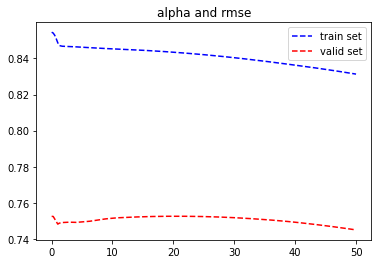

In [55]:
plt.plot(alphas, train_raw_r2, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_r2, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

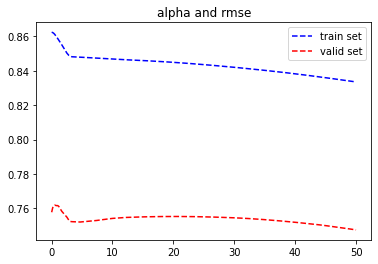

In [311]:
plt.plot(alphas, train_raw_r2, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_r2, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

#### RMSE(추정오차의 표준편차) 시각화

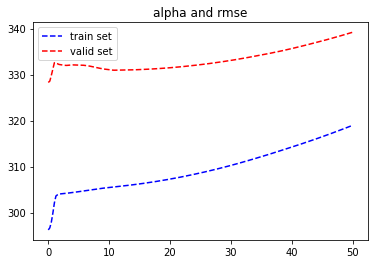

In [56]:
plt.plot(alphas, train_raw_rmse, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_rmse, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

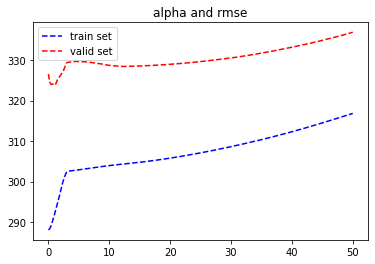

In [312]:
plt.plot(alphas, train_raw_rmse, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_rmse, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 모델을 학습시키고 test 셋을 예측하자

`-` 학습데이터는 표본 전부 사용(모델 성능는 위에서 교차검증을 통해 확인했으니까)

`-` 물론 최적 $\alpha$가 조금 달라지겠지만 큰 차이는 아니므로 괜찮다

In [99]:
my_lasso = Lasso(alpha = 27, max_iter = 150000, random_state = 21)
my_lasso2 = Lasso(alpha = 0.8, max_iter = 150000, random_state = 21)

In [100]:
my_lasso.fit(my_scaled_df, target)
my_lasso2.fit(my_scaled_df, target)

Lasso(alpha=0.8, max_iter=150000, random_state=21)

In [101]:
list(zip(my_scaled_df.columns, my_lasso.coef_))

[('Species', 0.0),
 ('Culmen_Length', 0.0),
 ('Culmen_Depth', -0.0),
 ('Flipper_Length', 341.19349058310866),
 ('Sex', 238.62796796729788),
 ('DeltaN', -151.62328086316543),
 ('DeltaC', -12.790844046911804),
 ('Sex_DeltaN', 0.0),
 ('Species_DeltaN', 0.0),
 ('Species_Culmen_Depth', 0.0),
 ('Species_Flipper_Length', 183.66878951731493)]

In [97]:
list(zip(my_scaled_df.columns, my_lasso2.coef_))

[('Species', -0.0),
 ('Culmen_Length', 13.842366022352914),
 ('Culmen_Depth', 33.410511794472),
 ('Flipper_Length', 187.30901707979004),
 ('Sex', 299.66537970021307),
 ('DeltaN', -93.97968826881377),
 ('DeltaC', -10.525559158550905),
 ('Sex_DeltaN', -30.453186182960724),
 ('Species_DeltaN', -676.9640428025973),
 ('Species_Culmen_Depth', -349.0551140123176),
 ('Species_Flipper_Length', 1407.2613563913867)]

In [383]:
lasso_test_predict = my_lasso.predict(test3_scaled_df)
lasso_test_predict2 = my_lasso2.predict(test3_scaled_df)

In [384]:
lasso_test_predict[:6], lasso_test_predict2[:6]

(array([4507.96033825, 5492.54673886, 3673.40612757, 3517.65815508,
        3234.62699202, 4306.08015104]),
 array([4374.71830855, 5550.08103443, 3594.56923065, 3426.87697269,
        3343.54873165, 4235.8119274 ]))

In [375]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = lasso_test_predict

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4507.960338
1,1,5492.546739
2,2,3673.406128
3,3,3517.658155
4,4,3234.626992


In [377]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_mylasso27.csv', index = False)

In [387]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = lasso_test_predict2

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4374.718309
1,1,5550.081034
2,2,3594.569231
3,3,3426.876973
4,4,3343.548732


In [388]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_mylasso0.8.csv', index = False)

`-` 점수는 273.265498098

### 릿지 회귀

In [319]:
train_raw_rmse_2, valid_raw_rmse_2 = [], []
train_raw_r2_2, valid_raw_r2_2 = [], []
alphas = np.linspace(0.01, 50, 300)

for alpha in alphas:
    my_ridge = Ridge(alpha = alpha, max_iter = 150000, random_state = 21)
    scores = cross_validate(my_ridge, my_scaled_df, target,
                            scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True, cv = kfold)
    
    train_raw_rmse_2.append(np.mean(list(map(get_rmse, scores['train_neg_mean_squared_error'])))) ## rmse
    valid_raw_rmse_2.append(np.mean(list(map(get_rmse, scores['test_neg_mean_squared_error']))))
    
    train_raw_r2_2.append(np.mean(scores['train_r2'])) ## r2
    valid_raw_r2_2.append(np.mean(scores['test_r2']))

#### $R^2$ 시각화

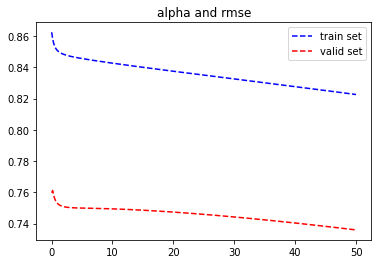

In [320]:
plt.plot(alphas, train_raw_r2_2, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_r2_2, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

#### RMSE(추정오차의 표준편차) 시각화

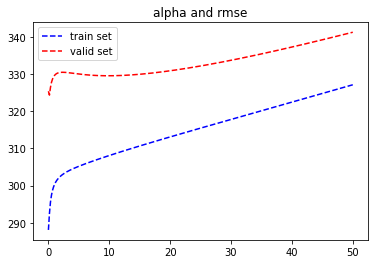

In [321]:
plt.plot(alphas, train_raw_rmse_2, 'b--', label = 'train set')
plt.plot(alphas, valid_raw_rmse_2, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

In [68]:
my_ridge = Ridge(alpha = 25, max_iter = 150000, random_state = 21)
my_ridge2 = Ridge(alpha = 1, max_iter = 150000, random_state = 21)

In [69]:
my_ridge.fit(my_scaled_df, target)
my_ridge2.fit(my_scaled_df, target)

Ridge(alpha=1, max_iter=150000, random_state=21)

In [96]:
list(zip(my_scaled_df.columns, my_ridge.coef_))

[('Species', 73.96480047924298),
 ('Culmen_Length', 17.601902217648824),
 ('Culmen_Depth', -37.414121082112345),
 ('Flipper_Length', 190.57309027751273),
 ('Sex', 146.11232758257674),
 ('DeltaN', -140.63731450840947),
 ('DeltaC', -69.79462785780501),
 ('Sex_DeltaN', 128.13633633989355),
 ('Species_DeltaN', 50.65621023728903),
 ('Species_Culmen_Depth', 54.31070165062659),
 ('Species_Flipper_Length', 99.03832316509904)]

In [392]:
ridge_test_predict = my_ridge.predict(test3_scaled_df)
ridge_test_predict2 = my_ridge2.predict(test3_scaled_df)

In [393]:
ridge_test_predict[:6], ridge_test_predict2[:6]

(array([4406.39892289, 5427.5788897 , 3617.83997354, 3584.88341635,
        3304.13072142, 4332.48060213]),
 array([4416.22387845, 5480.45443987, 3597.03935084, 3462.03646171,
        3227.73313425, 4261.34120906]))

In [156]:
# 제출용 sample 파일을 불러옴
submission = pd.read_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/sample_submission.csv')

In [379]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = ridge_test_predict

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4406.398923
1,1,5427.578890
2,2,3617.839974
3,3,3584.883416
4,4,3304.130721


In [380]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_myridge25.csv', index = False)

In [394]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = ridge_test_predict2

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4416.223878
1,1,5480.454440
2,2,3597.039351
3,3,3462.036462
4,4,3227.733134


In [395]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_myridge1.csv', index = False)

`-` 점수는 284.1045115676

`-` 릿지 회귀보다 라쏘 회귀가 좋다

## 교호작용항 세심하게 만들기2

`-` Full_Clutch만 제외함

In [29]:
x_train_raw.head()

,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
85,2,0,0,49.0,16.1,216,1,8.10417,-25.50562
98,2,0,1,49.1,15.0,228,1,8.65914,-25.79203
69,2,0,1,50.0,15.9,224,1,8.20042,-26.39677
0,2,0,1,50.0,15.3,220,1,8.30515,-25.19017
22,2,0,1,43.5,15.2,213,0,8.21634,-26.11046


In [102]:
raw_x2 = dt.copy()

In [103]:
raw_x2.drop('Full_Clutch', axis = 1, inplace = True)

`-` 교호작용 추가

In [104]:
raw_x2['Species_Culmen_Depth'] = raw_x2['Species'] * raw_x2['Culmen_Depth']
raw_x2['Species_Flipper_Length'] = raw_x2['Species'] * raw_x2['Flipper_Length']

raw_x2['Island_Culmen_Length'] = raw_x2['Island'] * raw_x2['Culmen_Length']

In [105]:
raw_x2.head()

,Species,Island,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Species_Culmen_Depth,Species_Flipper_Length,Island_Culmen_Length
0,2,0,50.0,15.3,220,1,8.30515,-25.19017,30.6,440,0.0
1,1,1,49.5,19.0,200,1,9.63074,-24.34684,19.0,200,49.5
2,2,0,45.1,14.4,210,0,8.51951,-27.01854,28.8,420,0.0
3,2,0,44.5,14.7,214,0,8.20106,-26.16524,29.4,428,0.0
4,2,0,49.6,16.0,225,1,8.38324,-26.84272,32.0,450,0.0


`-` 표준화를 해주자

In [106]:
## 스케일러 생성
my_scaler2 = StandardScaler()

## 전체 데이터셋 정규화
my_scaled2 = my_scaler2.fit_transform(raw_x2)
my_scaled_df2 = pd.DataFrame(data = my_scaled2, columns = raw_x2.columns)

`-` train에서 fit한 라벨인코딩을 사용하여 test셋을 transform하자

In [132]:
test4 = test.copy()

In [133]:
test4.drop('Full_Clutch', axis = 1, inplace = True)

In [134]:
test_species_labels = species_encoder.transform(test4['Species'])
test4['Species'] = list(test_species_labels) ## Species labelencoding

test_island_labels = island_encoder.transform(test4['Island'])
test4['Island'] = list(test_island_labels) ## Island labelencoding

# test_full_clutch_labels = full_clutch_encoder.transform(test2['Full_Clutch'])
# test2['Full_Clutch'] = list(test_full_clutch_labels) ## Full_Clutch labelencoding

test_sex_labels = sex_encoder.transform(test4['Sex'])
test4['Sex'] = list(test_sex_labels) ## Sex labelencoding

In [135]:
test4.head()

,Species,Island,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,1,1,52.0,20.7,210.0,1,9.43146,-24.68440
1,2,0,55.9,17.0,228.0,1,8.31180,-26.35425
2,0,1,38.9,18.8,190.0,0,8.36936,-26.11199
3,1,1,45.2,16.6,191.0,0,9.62357,-24.78984
4,0,0,37.9,18.6,172.0,0,8.38404,-25.19837


`-` 라벨 인코딩이 잘 되었다

`-` 교호작용항을 추가해주자

In [136]:
test4['Species_Culmen_Depth'] = test4['Species'] * test4['Culmen_Depth']
test4['Species_Flipper_Length'] = test4['Species'] * test4['Flipper_Length']

test4['Island_Culmen_Length'] = test4['Island'] * test4['Culmen_Length']

In [137]:
test4.shape

(228, 11)

`-` 위에서 train셋을 이용해 학습한 스케일러의 평균과 표준편차

In [138]:
## 테스트집합 정규화
test4_scaled = my_scaler2.transform(test4) ## x_train에서 학습한 정규화방식을 그대로 test_poly에 적용
test4_scaled_df = pd.DataFrame(data = test4_scaled, columns = test4.columns)

In [139]:
test4_scaled_df.head() ## 정규화가 잘 되었는지 확인

,Species,Island,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC,Species_Culmen_Depth,Species_Flipper_Length,Island_Culmen_Length
0,-0.069663,0.565966,1.394155,1.906577,0.476205,1.0,1.248586,1.235845,0.291266,-0.086430,0.928583
1,1.064848,-0.900401,2.130221,-0.007715,1.710011,1.0,-0.758321,-0.739407,1.281218,1.187935,-0.924643
2,-1.204174,0.565966,-1.078273,0.923562,-0.894689,-1.0,-0.655149,-0.452839,-1.249486,-1.174303,0.461712
3,-0.069663,0.565966,0.110758,-0.214666,-0.826144,-1.0,1.592929,1.111120,-0.013907,-0.184857,0.686238
4,-1.204174,-0.900401,-1.267007,0.820087,-2.128494,-1.0,-0.628836,0.627874,-1.249486,-1.174303,-0.924643


In [272]:
from sklearn.model_selection import KFold

In [162]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 21)

### 라쏘 회귀

`-` 라쏘 회귀의 $\alpha$ 선택 ---> $\alpha = 7$이 좋아보임

In [171]:
train_raw2_rmse, valid_raw2_rmse = [], []
train_raw2_r2, valid_raw2_r2 = [], []
alphas = np.linspace(0.01, 50, 300)

for alpha in alphas:
    my_lasso = Lasso(alpha = alpha, max_iter = 150000, random_state = 21)
    scores = cross_validate(my_lasso, my_scaled_df2, target,
                            scoring = ('r2', 'neg_mean_squared_error'), return_train_score = True, cv = kfold)
    
    train_raw2_rmse.append(np.mean(list(map(get_rmse, scores['train_neg_mean_squared_error'])))) ## rmse
    valid_raw2_rmse.append(np.mean(list(map(get_rmse, scores['test_neg_mean_squared_error']))))
    
    train_raw2_r2.append(np.mean(scores['train_r2'])) ## r2
    valid_raw2_r2.append(np.mean(scores['test_r2']))

#### $R^2$ 시각화

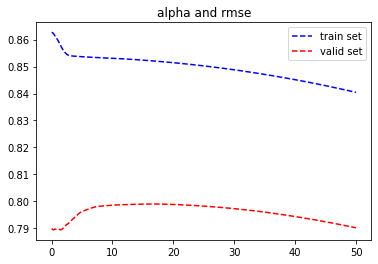

In [166]:
plt.plot(alphas, train_raw2_r2, 'b--', label = 'train set')
plt.plot(alphas, valid_raw2_r2, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

#### RMSE(추정오차의 표준편차) 시각화

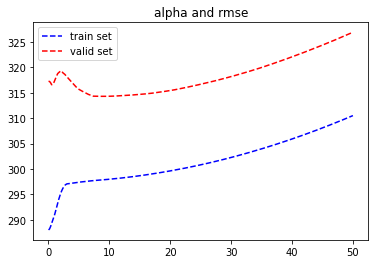

In [167]:
plt.plot(alphas, train_raw2_rmse, 'b--', label = 'train set')
plt.plot(alphas, valid_raw2_rmse, 'r--', label = 'valid set')
plt.title('alpha and rmse')
plt.legend()

`-` 모델을 학습시키고 test 셋을 예측하자

`-` 학습데이터는 표본 전부 사용(모델 성능는 위에서 교차검증을 통해 확인했으니까)

`-` 물론 최적 $\alpha$가 조금 달라지겠지만 큰 차이는 아니므로 괜찮다

In [172]:
my_lasso3 = Lasso(alpha = 7, max_iter = 150000, random_state = 21)

In [173]:
my_lasso3.fit(my_scaled_df2, target)

Lasso(alpha=7, max_iter=150000, random_state=21)

In [114]:
list(zip(my_scaled_df2.columns, my_lasso3.coef_))

[('Species', 0.0),
 ('Island', -0.0),
 ('Culmen_Length', 0.0),
 ('Culmen_Depth', -0.0),
 ('Flipper_Length', 291.0156506665558),
 ('Sex', 278.8937497462744),
 ('DeltaN', -166.32566347860111),
 ('DeltaC', -0.04831095327177225),
 ('Species_Culmen_Depth', 0.0),
 ('Species_Flipper_Length', 177.216390281056),
 ('Island_Culmen_Length', -96.45281079656215)]

`-` Culmen_Depth는 무의미한 변수인가 보다

In [141]:
lasso_test_predict3 = my_lasso3.predict(test4_scaled_df)

In [143]:
lasso_test_predict3[:6]

array([4432.71504484, 5530.25452598, 3644.93948211, 3444.58837465,
       3415.17207639, 4285.76749866])

In [146]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = lasso_test_predict3

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4432.715045
1,1,5530.254526
2,2,3644.939482
3,3,3444.588375
4,4,3415.172076


In [147]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_mylasso3_7.csv', index = False)

### 라쏘 회귀 + 교차검증을 사용한 예측

`-` Island와 Full_Clutch 피쳐는 무의미(포함하면 성능이 안좋아짐)

`-` 5등분된 뗑컨

In [392]:
kfold = KFold(n_splits = 5, shuffle = True, random_state = 2021)

In [393]:
predict_test4_2 = []
train_rmse10_2 = []
valid_rmse10_2 = []
lasso_k = Lasso(alpha = 7, max_iter = 50000, random_state = 21) ## 라쏘회귀모형 정의

for train_index, valid_index in kfold.split(my_scaled_df2):
    ## train, valid 데이터 extract
    xx_train, xx_valid = my_scaled_df2.iloc[train_index], my_scaled_df2.iloc[valid_index]
    yy_train, yy_valid = target.iloc[train_index], target.iloc[valid_index]

    lasso_k.fit(xx_train, yy_train) ## 훈련

    train_predict = lasso_k.predict(xx_train) ## train셋 예측
    y_predict = lasso_k.predict(xx_valid) ## valid셋 예측
    test_predict = lasso_k.predict(test4_scaled_df) ## test셋 예측

    predict_test4_2.append(test_predict) ## test 예측값
    train_rmse10_2.append(RMSE(train_predict, yy_train)) ## train rmse
    valid_rmse10_2.append(RMSE(y_predict, yy_valid)) ## valid rmse

In [394]:
np.mean(train_rmse10_2), np.mean(valid_rmse10_2)

(297.068435687834, 306.71671098203325)

In [395]:
body_mass = 0
for i in range(5):
    body_mass += predict_test4_2[i]
    
body_mass /= 5

In [396]:
body_mass[:6]

array([4423.45442416, 5527.19260495, 3640.32403981, 3444.72790364,
       3406.20233912, 4278.59919678])

In [397]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = body_mass

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4423.454424
1,1,5527.192605
2,2,3640.324040
3,3,3444.727904
4,4,3406.202339


In [332]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission13.csv', index = False)

`-` 10등분된 뗑컨

In [398]:
kfold = KFold(n_splits = 10, shuffle = True, random_state = 10)

In [399]:
predict_test4_2 = []
train_rmse10_2 = []
valid_rmse10_2 = []
lasso_k = Lasso(alpha = 7, max_iter = 50000, random_state = 21) ## 라쏘회귀모형 정의

for train_index, valid_index in kfold.split(my_scaled_df2):
    ## train, valid 데이터 extract
    xx_train, xx_valid = my_scaled_df2.iloc[train_index], my_scaled_df2.iloc[valid_index]
    yy_train, yy_valid = target.iloc[train_index], target.iloc[valid_index]

    lasso_k.fit(xx_train, yy_train) ## 훈련

    train_predict = lasso_k.predict(xx_train) ## train셋 예측
    y_predict = lasso_k.predict(xx_valid) ## valid셋 예측
    test_predict = lasso_k.predict(test4_scaled_df) ## test셋 예측

    predict_test4_2.append(test_predict) ## test 예측값
    train_rmse10_2.append(RMSE(train_predict, yy_train)) ## train rmse
    valid_rmse10_2.append(RMSE(y_predict, yy_valid)) ## valid rmse

In [400]:
np.mean(train_rmse10_2), np.mean(valid_rmse10_2)

(297.5743069692427, 308.7221417631247)

In [401]:
body_mass = 0
for i in range(10):
    body_mass += predict_test4_2[i]
    
body_mass /= 10

In [402]:
body_mass[:6]

array([4424.59061711, 5528.02801722, 3644.32224525, 3449.02645699,
       3408.87833228, 4279.32309958])

In [403]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = body_mass

# 데이터가 잘 들어갔는지 확인
submission.head()

,id,Body Mass (g)
0,0,4424.590617
1,1,5528.028017
2,2,3644.322245
3,3,3449.026457
4,4,3408.878332


In [374]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission14.csv', index = False)

`-` 5등분과 10등분의 값차이는 크지않음

`-` 일반화 성능은 10등분이 나을 것 같음

## Species마다 모델 만들기

`-` Species는 3가지 범주를 가지는데 범주마다 모델을 만들것임

In [54]:
ori_dt = pd.concat([target, dt], axis = 1)

In [55]:
ori_dt.head()

,Body_Mass,Species,Island,Full_Clutch,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,5550,2,0,1,50.0,15.3,220,1,8.30515,-25.19017
1,3800,1,1,0,49.5,19.0,200,1,9.63074,-24.34684
2,4400,2,0,1,45.1,14.4,210,0,8.51951,-27.01854
3,4850,2,0,1,44.5,14.7,214,0,8.20106,-26.16524
4,5700,2,0,0,49.6,16.0,225,1,8.38324,-26.84272


`-` 안 쓰는 피쳐 드랍

In [56]:
data = ori_dt.drop(['Full_Clutch', 'Island'], axis = 1) ## Island와 Full_Clutch 피쳐는 사용 X

`-` 교호작용항 추가는 나중에 고려해보자

In [57]:
data.head()

,Body_Mass,Species,Culmen_Length,Culmen_Depth,Flipper_Length,Sex,DeltaN,DeltaC
0,5550,2,50.0,15.3,220,1,8.30515,-25.19017
1,3800,1,49.5,19.0,200,1,9.63074,-24.34684
2,4400,2,45.1,14.4,210,0,8.51951,-27.01854
3,4850,2,44.5,14.7,214,0,8.20106,-26.16524
4,5700,2,49.6,16.0,225,1,8.38324,-26.84272


In [58]:
dt0 = data.copy()
dt1 = data.copy()
dt2 = data.copy()

In [59]:
dt0 = dt0.query('Species == 0')
dt1 = dt1.query('Species == 1')
dt2 = dt2.query('Species == 2')

`-` Speceis는 이제 역할을 다 했으므로 드랍한다

In [60]:
dt0.drop('Species', axis = 1, inplace = True)
dt1.drop('Species', axis = 1, inplace = True)
dt2.drop('Species', axis = 1, inplace = True)

`-` 피쳐와 타겟 분리

In [61]:
## target
target0 = dt0.iloc[:,0]
target1 = dt1.iloc[:,0]
target2 = dt2.iloc[:,0]

In [62]:
## feature
dt0 = dt0.iloc[:,1:]
dt1 = dt1.iloc[:,1:]
dt2 = dt2.iloc[:,1:]

`-` 표준화

In [160]:
# dt0
## 스케일러 생성
scaler0 = StandardScaler()

## 정규화
dt0_scaled = scaler0.fit_transform(dt0)
dt0_scaled_df = pd.DataFrame(data = dt0_scaled, columns = dt0.columns)


# dt1
## 스케일러 생성
scaler1 = StandardScaler()

## 정규화
dt1_scaled = scaler1.fit_transform(dt1)
dt1_scaled_df = pd.DataFrame(data = dt1_scaled, columns = dt1.columns)


# dt2
## 스케일러 생성
scaler2 = StandardScaler()

## 정규화
dt2_scaled = scaler2.fit_transform(dt2)
dt2_scaled_df = pd.DataFrame(data = dt2_scaled, columns = dt2.columns)

`-` 방사성 동위 원소 피쳐를 드랍한 데이터프레임

In [477]:
lin_dt0_scaled_df = dt0_scaled_df.copy()
lin_dt1_scaled_df = dt1_scaled_df.copy()
lin_dt2_scaled_df = dt2_scaled_df.copy()

In [478]:
lin_dt0_scaled_df.drop(['DeltaN', 'DeltaC'], axis = 1, inplace = True)
lin_dt1_scaled_df.drop(['DeltaN', 'DeltaC'], axis = 1, inplace = True)
lin_dt2_scaled_df.drop(['DeltaN', 'DeltaC'], axis = 1, inplace = True)

`-` 교차검증 준비

In [33]:
dt_kfold = KFold(n_splits = 3, shuffle = True, random_state = 21)

### 라쏘 회귀

`-` 모델은 라쏘회귀(무의미한 피쳐의 계수를 $0$으로 만듦)를 사용하고 평가는 교차 검증을 사용

`-` K겹 교차검증을 통해 최적의 $\alpha$를 찾는다

`-` Species별로 데이터를 나누다보니 표본 크기가 작아 $R^2$가 train, valid 격차가 너무 커서 제외함 

`-` dt0에 대한 모델

In [514]:
dt0_train_rmse_list, dt0_valid_rmse_list = [], []
alphas = np.linspace(0.01, 100, 300) ## 알파

for alpha in alphas:
    lasso_kfold = Lasso(alpha = alpha, max_iter = 80000, random_state = 21)
    
    scores = cross_validate(lasso_kfold, lin_dt0_scaled_df, # dt0_scaled_df ## 둘 중 하나 선택
                            target0.reset_index().drop('index', axis = 1),
                            scoring = ('neg_mean_squared_error'), return_train_score = True, cv = dt_kfold)

    dt0_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
    dt0_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

#### dt0에 대한 RMSE 시각화

`-` 방사성 동위 원소 피쳐 드랍(서브 플랏으로 보여줘도 좋을 것 같다)

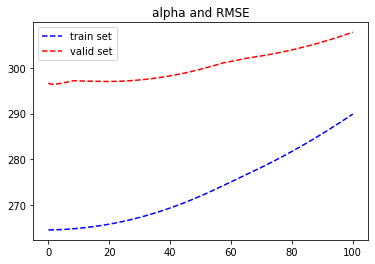

In [515]:
plt.plot(alphas, dt0_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt0_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` 방사성 동위 원소 피쳐 드랍X

`-` $\alpha = 8.75$

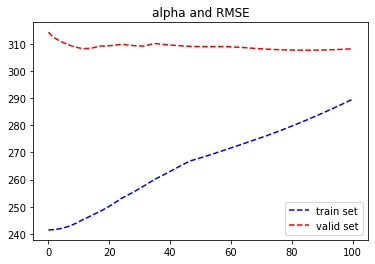

In [319]:
plt.plot(alphas, dt0_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt0_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 8.75$로 하자(뭘로 할 지 모르겠다)

`-` dt1에 대한 모델

In [510]:
dt1_train_rmse_list, dt1_valid_rmse_list = [], []
alphas = np.linspace(0.01, 50, 300) ## 알파

for alpha in alphas:
    lasso_kfold = Lasso(alpha = alpha, max_iter = 80000, random_state = 21)
    
    scores = cross_validate(lasso_kfold, lin_dt1_scaled_df, target1.reset_index().drop('index', axis = 1),
                            scoring = 'neg_mean_squared_error', return_train_score = True, cv = dt_kfold)

    dt1_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
    dt1_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

#### dt1에 대한 RMSE 시각화

`-` 방사성 동위 원소 피쳐 드랍

`-` 드랍 안한 모델 성능이 더 좋아보인다

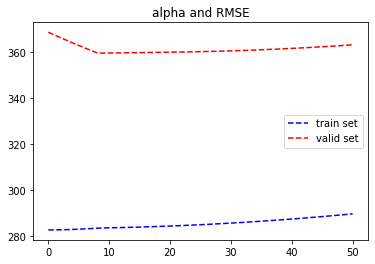

In [511]:
plt.plot(alphas, dt1_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt1_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` 방사성 동위 원소 피쳐 드랍X

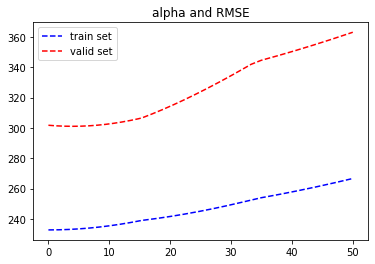

In [327]:
plt.plot(alphas, dt1_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt1_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha=5$로 하자

`-` 모델 예측할 때는 모든 데이터를 학습하는데 사용할 것이므로 test셋에 대해 train, valid 격차만큼 차이가 나진 않을 것

`-` dt2에 대한 모델

In [566]:
dt2_train_rmse_list, dt2_valid_rmse_list = [], []
alphas = np.linspace(0.01, 100, 350) ## 알파

for alpha in alphas:
    lasso_kfold = Lasso(alpha = alpha, max_iter = 80000, random_state = 21)
    
    scores = cross_validate(lasso_kfold, lin_dt2_scaled_df, target2.reset_index().drop('index', axis = 1),
                            scoring = 'neg_mean_squared_error', return_train_score = True, cv = dt_kfold)

    dt2_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
    dt2_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

#### dt2에 대한 RMSE 시각화

`-` 방사성 동위 원소 피쳐 드랍

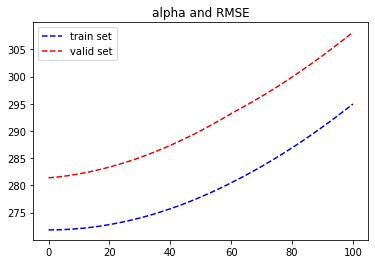

In [513]:
plt.plot(alphas, dt2_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt2_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 1$로 하자

`-` 방사성 동위 원소 피쳐 드랍X

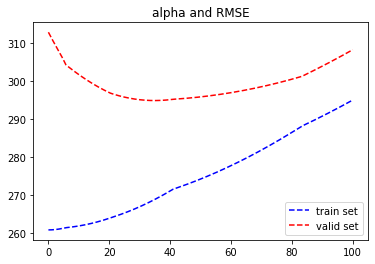

In [321]:
plt.plot(alphas, dt2_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt2_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 30$으로 하자

### 릿지 회귀

`-` dt0에 대한 모델

In [494]:
dt0_train_rmse_list, dt0_valid_rmse_list = [], []
alphas = np.linspace(0.01, 20, 200) ## 알파

for alpha in alphas:
    ridge_kfold = Ridge(alpha = alpha, max_iter = 80000, random_state = 21)
    
    scores = cross_validate(ridge_kfold, lin_dt0_scaled_df, target0.reset_index().drop('index', axis = 1),
                            scoring = ('neg_mean_squared_error'), return_train_score = True, cv = dt_kfold)

    dt0_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
    dt0_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

#### dt0에 대한 RMSE 시각화

`-` 방사성 동위 원소 피쳐 드랍

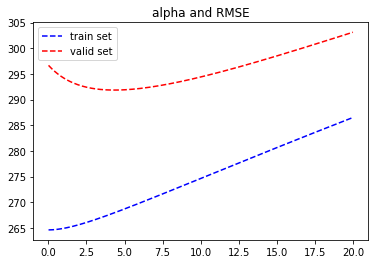

In [495]:
plt.plot(alphas, dt0_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt0_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 4$

`-` 방사성 동위 원소 피쳐 드랍X

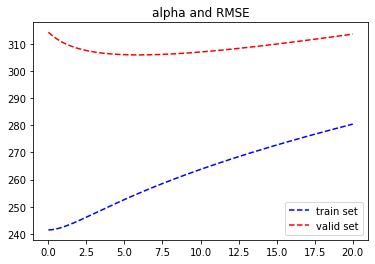

In [235]:
plt.plot(alphas, dt0_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt0_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 7$로 하자

`-` dt1에 대한 모델

In [496]:
dt1_train_rmse_list, dt1_valid_rmse_list = [], []
alphas = np.linspace(0.01, 20, 200) ## 알파

for alpha in alphas:
    ridge_kfold = Ridge(alpha = alpha, max_iter = 80000, random_state = 21)
    
    scores = cross_validate(ridge_kfold, lin_dt1_scaled_df, target1.reset_index().drop('index', axis = 1),
                            scoring = 'neg_mean_squared_error', return_train_score = True, cv = dt_kfold)

    dt1_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
    dt1_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

#### dt1에 대한 RMSE 시각화

`-` 방사성 동위 원소 피쳐 드랍

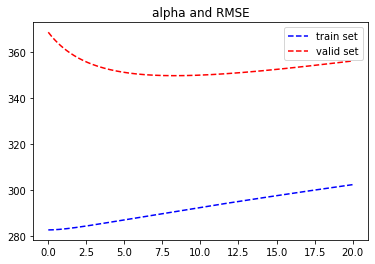

In [497]:
plt.plot(alphas, dt1_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt1_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 7$

`-` 방사성 동위 원소 피쳐 드랍X

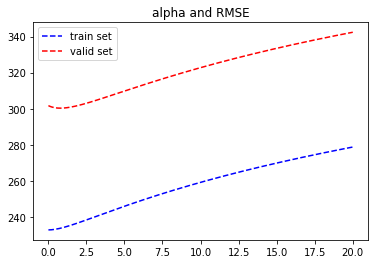

In [311]:
plt.plot(alphas, dt1_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt1_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 1$로 하자

`-` 모델 예측할 때는 모든 데이터를 학습하는데 사용할 것이므로 test셋에 대해 train, valid 격차만큼 차이가 나진 않을 것

`-` dt2에 대한 모델

In [500]:
dt2_train_rmse_list, dt2_valid_rmse_list = [], []
alphas = np.linspace(0.01, 100, 300) ## 알파

for alpha in alphas:
    ridge_kfold = Ridge(alpha = alpha, max_iter = 80000, random_state = 21)
    
    scores = cross_validate(ridge_kfold, lin_dt2_scaled_df, target2.reset_index().drop('index', axis = 1),
                            scoring = 'neg_mean_squared_error', return_train_score = True, cv = dt_kfold)

    dt2_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
    dt2_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

#### dt2에 대한 RMSE 시각화

`-` 방사성 동위 원소 피쳐 드랍

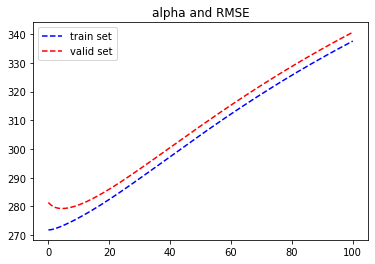

In [501]:
plt.plot(alphas, dt2_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt2_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 4.5$ 

`-` 방사성 동위 원소 피쳐 드랍X

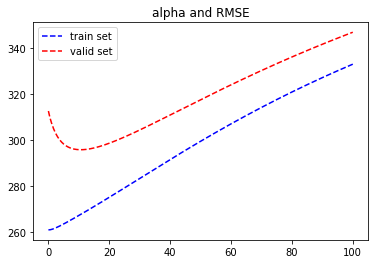

In [423]:
plt.plot(alphas, dt2_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt2_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 10$으로 하자

### 선형 회귀

`-` 선형 회귀는 라쏘 회귀나 릿지 회귀와 달리 규제항이 없다

`-` EDA를 보면 알겠지만 방사성 동위 원소에 대해 Species 범주에 따른 파샬 상관관계를 보면 

`-` 방사성 동위 원소 피쳐는 몸무게와 상관관계가 거의 없는 것으로 보인다

`-` 그렇기에 규제항이 없는 선형 회귀에서는 두 피쳐를 제외하겠다

`-` dt0에 대한 모델

In [121]:
from sklearn.linear_model import LinearRegression

In [594]:
dt0_train_rmse_list, dt0_valid_rmse_list = [], []
linear_kfold = LinearRegression()

scores = cross_validate(linear_kfold, lin_dt0_scaled_df, target0.reset_index().drop('index', axis = 1),
                        scoring = ('neg_mean_squared_error'), return_train_score = True, cv = dt_kfold)

dt0_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
dt0_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

`-` dt0에 대한 RMSE

In [595]:
dt0_train_rmse_list, dt0_valid_rmse_list

([264.62786746527405], [296.698184588013])

`-` dt1에 대한 모델

`-` DeltaC만 드랍, DeltaN은 사용

In [661]:
drop_dt1_scaled_df = dt1_scaled_df.copy()
drop_dt1_scaled_df.drop('DeltaC', axis = 1, inplace = True)

In [663]:
dt1_train_rmse_list, dt1_valid_rmse_list = [], []
linear_kfold = LinearRegression()

scores = cross_validate(linear_kfold, drop_dt1_scaled_df, target1.reset_index().drop('index', axis = 1),
                        scoring = ('neg_mean_squared_error'), return_train_score = True, cv = dt_kfold)

dt1_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
dt1_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

`-` dt1에 대한 RMSE

`-` 피쳐를 드랍안한 것이 train, valid 둘 다에 대해서 rmse가 작다

`-` 내 생각에 피쳐를 드랍한 것이 더 좋아야 할 것 가다(몸무게와 상관관계가 약함)

`-` 오버피팅인 것 같음

In [664]:
dt1_train_rmse_list, dt1_valid_rmse_list

([255.87474087498182], [344.45905458957935])

`-` dt2에 대한 모델

In [590]:
dt2_train_rmse_list, dt2_valid_rmse_list = [], []
linear_kfold = LinearRegression()

scores = cross_validate(linear_kfold, lin_dt2_scaled_df, target2.reset_index().drop('index', axis = 1),
                        scoring = ('neg_mean_squared_error'), return_train_score = True, cv = dt_kfold)

dt2_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
dt2_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

`-` dt2에 대한 RMSE

In [591]:
dt2_train_rmse_list, dt2_valid_rmse_list

([271.820982844474], [281.3911724680493])

### 위의 3가지 모형 각각의 test 예측

`-` Chinstrap 뗑컨에 대해서는 선형 회귀가 잘 맞춘다

In [135]:
tt0 = test3.copy()
tt1 = test3.copy()
tt2 = test3.copy()

In [136]:
tt0 = tt0.query('Species == 0')
tt1 = tt1.query('Species == 1')
tt2 = tt2.query('Species == 2')

`-` 효용 가치를 다 한 Species 변수 제거

In [137]:
tt0.drop('Species', axis = 1, inplace = True)
tt1.drop('Species', axis = 1, inplace = True)
tt2.drop('Species', axis = 1, inplace = True)

`-` 테스트 집합 스케일링

In [298]:
## 테스트집합 표준화
tt0_scaled = scaler0.transform(tt0) ## train에서 학습한 스케일링 방식을 그대로 test에 적용
tt0_scaled_df = pd.DataFrame(data = tt0_scaled, columns = tt0.columns)
tt0_scaled_df.set_index(tt0.index, inplace = True)


tt1_scaled = scaler1.transform(tt1)
tt1_scaled_df = pd.DataFrame(data = tt1_scaled, columns = tt1.columns)
tt1_scaled_df.set_index(tt1.index, inplace = True)


tt2_scaled = scaler1.transform(tt2) 
tt2_scaled_df = pd.DataFrame(data = tt2_scaled, columns = tt2.columns)
tt2_scaled_df.set_index(tt2.index, inplace = True)

`-` 방사성 동위 원소 피쳐 드랍

In [489]:
lin_tt0_scaled_df = tt0_scaled_df.copy()
lin_tt1_scaled_df = tt1_scaled_df.copy()
lin_tt2_scaled_df = tt2_scaled_df.copy()

In [490]:
lin_tt0_scaled_df.drop(['DeltaN', 'DeltaC'], axis = 1, inplace = True)
lin_tt1_scaled_df.drop(['DeltaN', 'DeltaC'], axis = 1, inplace = True)
lin_tt2_scaled_df.drop(['DeltaN', 'DeltaC'], axis = 1, inplace = True)

`-` 라쏘 회귀

In [649]:
lasso_tt0 = Lasso(alpha = 8.75, max_iter = 80000, random_state = 21)
lasso_tt1 = Lasso(alpha = 5, max_iter = 80000, random_state = 21)
lasso_tt2 = Lasso(alpha = 0.4, max_iter = 80000, random_state = 21)

In [650]:
lasso_tt0.fit(dt0_scaled_df, target0.reset_index().drop('index', axis = 1))
lasso_tt1.fit(dt1_scaled_df, target1.reset_index().drop('index', axis = 1))
lasso_tt2.fit(lin_dt2_scaled_df, target2.reset_index().drop('index', axis = 1))

Lasso(alpha=0.4, max_iter=80000, random_state=21)

In [570]:
predict_tt0 = lasso_tt0.predict(tt0_scaled_df)
predict_tt1 = lasso_tt1.predict(tt1_scaled_df)
predict_tt2 = lasso_tt2.predict(lin_tt2_scaled_df) 
# predict_tt2 = lasso_tt2.predict(tt2_scaled_df) 

In [571]:
tt0['Body_Mass'] = predict_tt0
tt1['Body_Mass'] = predict_tt1
tt2['Body_Mass'] = predict_tt2

`-` Species가 Adelie인 경우 방사성 동위 원소 피쳐를 드랍한 버전

In [574]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = pd.concat([tt0, tt1, tt2]).reset_index().sort_values('index').set_index('index').Body_Mass

# 데이터가 잘 들어갔는지 확인
submission.head() 

,id,Body Mass (g)
0,0,4402.161286
1,1,5697.660454
2,2,3536.722634
3,3,3476.208287
4,4,3384.491826


In [575]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_species_lasso_drop.csv', index = False)

`-` 드랍 X

In [469]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = pd.concat([tt0, tt1, tt2]).reset_index().sort_values('index').set_index('index').Body_Mass

# 데이터가 잘 들어갔는지 확인
submission.head() 

,id,Body Mass (g)
0,0,4402.161286
1,1,5610.954836
2,2,3536.722634
3,3,3476.208287
4,4,3384.491826


In [470]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_species_lasso.csv', index = False)

`-` 선형 회귀

In [684]:
linear_tt0 = LinearRegression()
linear_tt1 = LinearRegression()
linear_tt2 = LinearRegression()

In [685]:
linear_tt0.fit(lin_dt0_scaled_df, target0.reset_index().drop('index', axis = 1))
linear_tt1.fit(drop_dt1_scaled_df, target1.reset_index().drop('index', axis = 1))
linear_tt2.fit(lin_dt2_scaled_df, target2.reset_index().drop('index', axis = 1))

LinearRegression()

In [668]:
drop_tt1_scaled_df = tt1_scaled_df.copy()
drop_tt1_scaled_df.drop('DeltaC', axis = 1, inplace = True)

In [686]:
predict_tt0 = linear_tt0.predict(lin_tt0_scaled_df)
predict_tt1 = linear_tt1.predict(drop_tt1_scaled_df)
predict_tt2 = linear_tt2.predict(lin_tt2_scaled_df)

In [687]:
tt0['Body_Mass'] = predict_tt0
tt1['Body_Mass'] = predict_tt1
tt2['Body_Mass'] = predict_tt2

In [688]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = pd.concat([tt0, tt1, tt2]).reset_index().sort_values('index').set_index('index').Body_Mass

# 데이터가 잘 들어갔는지 확인
submission.head() 

,id,Body Mass (g)
0,0,4304.650292
1,1,5698.523434
2,2,3527.813603
3,3,3309.868869
4,4,3322.669004


In [673]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_species_linear3.csv', index = False)
# linear1은 lin_dt1 사용, linear2는 dt1 사용

`-` 릿지 회귀

In [522]:
ridge_tt0 = Ridge(alpha = 4, max_iter = 80000, random_state = 21)
ridge_tt1 = Ridge(alpha = 1, max_iter = 80000, random_state = 21)
ridge_tt2 = Ridge(alpha = 4.5, max_iter = 80000, random_state = 21)

In [523]:
ridge_tt0.fit(lin_dt0_scaled_df, target0.reset_index().drop('index', axis = 1))
ridge_tt1.fit(dt1_scaled_df, target1.reset_index().drop('index', axis = 1))
ridge_tt2.fit(lin_dt2_scaled_df, target2.reset_index().drop('index', axis = 1))

Ridge(alpha=4.5, max_iter=80000, random_state=21)

In [525]:
predict_tt0 = ridge_tt0.predict(lin_tt0_scaled_df)
predict_tt1 = ridge_tt1.predict(tt1_scaled_df)
predict_tt2 = ridge_tt2.predict(lin_tt2_scaled_df)

In [526]:
tt0['Body_Mass'] = predict_tt0
tt1['Body_Mass'] = predict_tt1
tt2['Body_Mass'] = predict_tt2

In [528]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = pd.concat([tt0, tt1, tt2]).reset_index().sort_values('index').set_index('index').Body_Mass

# 데이터가 잘 들어갔는지 확인
submission.head() 

,id,Body Mass (g)
0,0,4408.390856
1,1,5690.871906
2,2,3573.968871
3,3,3467.255017
4,4,3360.998001


In [529]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_species_ridge.csv', index = False)

## Species 마다 모델 만들기 + 교호작용

`-` Sex 피쳐에 대해서 교호작용을 추가해보자

In [64]:
poly_dt0 = poly(dt0)
poly_dt1 = poly(dt1)
poly_dt2 = poly(dt2)

`-` 표준화

In [67]:
# dt0
## 스케일러 생성
poly_scaler0 = StandardScaler()

## 표준화
poly_dt0_scaled = poly_scaler0.fit_transform(poly_dt0)
poly_dt0_scaled_df = pd.DataFrame(data = poly_dt0_scaled, columns = poly_dt0.columns)


# dt1
## 스케일러 생성
poly_scaler1 = StandardScaler()

## 표준화
poly_dt1_scaled = poly_scaler1.fit_transform(poly_dt1)
poly_dt1_scaled_df = pd.DataFrame(data = poly_dt1_scaled, columns = poly_dt1.columns)


# dt2
## 스케일러 생성
poly_scaler2 = StandardScaler()

## 표준화
poly_dt2_scaled = poly_scaler2.fit_transform(poly_dt2)
poly_dt2_scaled_df = pd.DataFrame(data = poly_dt2_scaled, columns = poly_dt2.columns)

### 라쏘회귀

`-` dt0에 대한 모델

In [77]:
dt0_train_rmse_list, dt0_valid_rmse_list = [], []
alphas = np.linspace(0.01, 1, 50) ## 알파

for alpha in alphas:
    lasso_kfold = Lasso(alpha = alpha, max_iter = 80000, random_state = 21)
    
    scores = cross_validate(lasso_kfold, poly_dt0_scaled_df, target0.reset_index().drop('index', axis = 1),
                            scoring = ('neg_mean_squared_error'), return_train_score = True, cv = dt_kfold)

    dt0_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
    dt0_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

#### dt0에 대한 RMSE 시각화

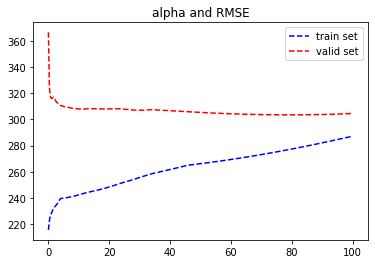

In [71]:
plt.plot(alphas, dt0_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt0_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 0.8$

`-` dt1에 대한 모델

In [102]:
dt1_train_rmse_list, dt1_valid_rmse_list = [], []
alphas = np.linspace(0.1, 30, 300) ## 알파

for alpha in alphas:
    lasso_kfold = Lasso(alpha = alpha, max_iter = 400000, random_state = 21)
    
    scores = cross_validate(lasso_kfold, poly_dt1_scaled_df, target1.reset_index().drop('index', axis = 1),
                            scoring = 'neg_mean_squared_error', return_train_score = True, cv = dt_kfold)

    dt1_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
    dt1_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

#### dt1에 대한 RMSE 시각화

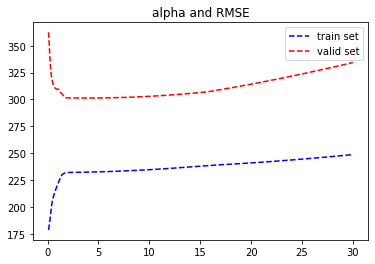

In [103]:
plt.plot(alphas, dt1_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt1_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha=2$로 하자

`-` dt2에 대한 모델

In [105]:
dt2_train_rmse_list, dt2_valid_rmse_list = [], []
alphas = np.linspace(0.01, 30, 300) ## 알파

for alpha in alphas:
    lasso_kfold = Lasso(alpha = alpha, max_iter = 400000, random_state = 21)
    
    scores = cross_validate(lasso_kfold, poly_dt2_scaled_df, target2.reset_index().drop('index', axis = 1),
                            scoring = 'neg_mean_squared_error', return_train_score = True, cv = dt_kfold)

    dt2_train_rmse_list.append(np.mean(list(map(get_rmse, scores['train_score'])))) ## rmse
    dt2_valid_rmse_list.append(np.mean(list(map(get_rmse, scores['test_score']))))

#### dt2에 대한 RMSE 시각화

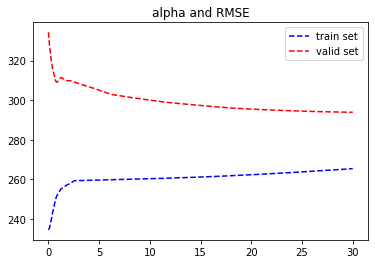

In [106]:
plt.plot(alphas, dt2_train_rmse_list, 'b--', label = 'train set')
plt.plot(alphas, dt2_valid_rmse_list, 'r--', label = 'valid set')
plt.title('alpha and RMSE')
plt.legend()

`-` $\alpha = 25$로 하자

`-` test 예측

In [143]:
poly_tt0 = poly(tt0)
poly_tt1 = poly(tt1)
poly_tt2 = poly(tt2)

In [145]:
## 테스트집합 표준화
poly_tt0_scaled = poly_scaler0.transform(poly_tt0) ## train에서 학습한 스케일링 방식을 그대로 test에 적용
poly_tt0_scaled_df = pd.DataFrame(data = poly_tt0_scaled, columns = poly_tt0.columns)
poly_tt0_scaled_df.set_index(poly_tt0.index, inplace = True)


poly_tt1_scaled = poly_scaler1.transform(poly_tt1)
poly_tt1_scaled_df = pd.DataFrame(data = poly_tt1_scaled, columns = poly_tt1.columns)
poly_tt1_scaled_df.set_index(poly_tt1.index, inplace = True)


poly_tt2_scaled = poly_scaler1.transform(poly_tt2) 
poly_tt2_scaled_df = pd.DataFrame(data = poly_tt2_scaled, columns = poly_tt2.columns)
poly_tt2_scaled_df.set_index(poly_tt2.index, inplace = True)

`-` Lasso 클래스의 인스턴스 생성

In [147]:
lasso0 = Lasso(alpha = 0.8, max_iter = 100000, random_state = 21)
lasso1 = Lasso(alpha = 2, max_iter = 100000, random_state = 21)
lasso2 = Lasso(alpha = 25, max_iter = 100000, random_state = 21)

`-` 모델 적합

In [150]:
lasso0.fit(poly_dt0_scaled_df, target0.reset_index().drop('index', axis = 1))
lasso1.fit(poly_dt1_scaled_df, target1.reset_index().drop('index', axis = 1))
lasso2.fit(poly_dt2_scaled_df, target2.reset_index().drop('index', axis = 1))

Lasso(alpha=25, max_iter=100000, random_state=21)

`-` 예측

In [152]:
predict0 = lasso0.predict(poly_tt0_scaled_df)
predict1 = lasso1.predict(poly_tt1_scaled_df)
predict2 = lasso2.predict(poly_tt2_scaled_df) 

In [159]:
poly_tt0['Body_Mass'] = predict0
poly_tt1['Body_Mass'] = predict1
poly_tt2['Body_Mass'] = predict2

In [161]:
# 위에서 구한 예측값을 그대로 넣음
submission['Body Mass (g)'] = pd.concat([poly_tt0, poly_tt1, poly_tt2]).reset_index().sort_values('index').set_index('index').Body_Mass

# 데이터가 잘 들어갔는지 확인
submission.head() 

,id,Body Mass (g)
0,0,4412.494687
1,1,5570.008212
2,2,3611.485750
3,3,3478.005751
4,4,3415.171373


In [165]:
# submission을 csv 파일로 저장
submission.to_csv('C:/Users/Jaesu/Dacon-Basic/뗑컨-몸무게-예측/Data/submission_species_poly_lasso.csv', index = False)